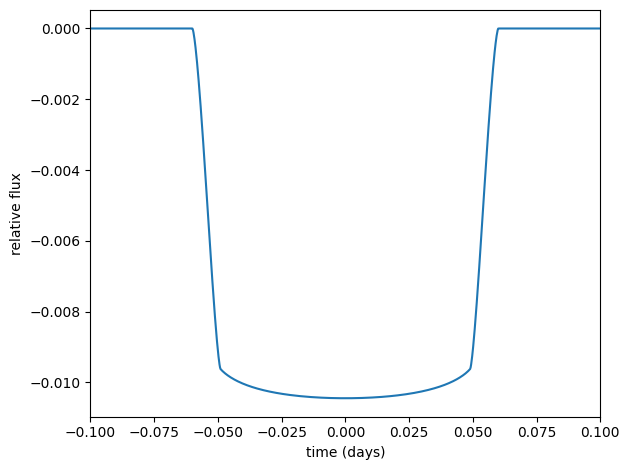

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

orbit = TransitOrbit(
    period=3.456, duration=0.12, time_transit=0.0, impact_param=0.1, radius_ratio=0.1
)

# Compute a limb-darkened light curve for this orbit
time = np.linspace(-0.1, 0.1, 1000)
u = [0.1, 0.06]  # Quadratic limb-darkening coefficients
light_curve = limb_dark_light_curve(orbit, u)(time)

# Plot the light curve
plt.plot(time, light_curve)
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
plt.tight_layout()

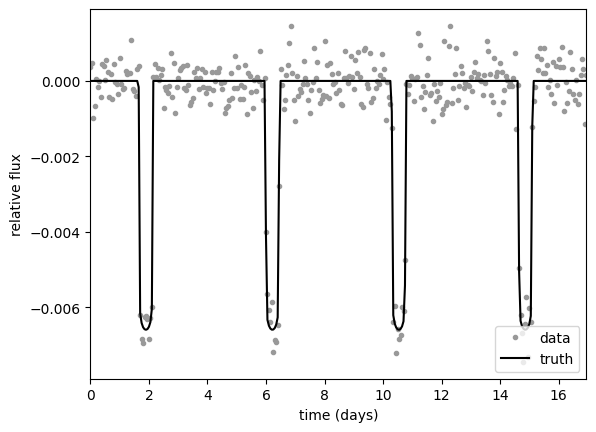

In [4]:
# Simulate some data with Gaussian noise
random = np.random.default_rng(42)
PERIOD = random.uniform(2, 5)  # day
T0 = PERIOD * random.uniform()  # day
DURATION = 0.5  # day
B = 0.5  # impact parameter
ROR = 0.08  # planet radius / star radius
U = np.array([0.1, 0.06])  # limb darkening coefficients
yerr = 5e-4  # flux uncertainty
time = np.arange(0, 17, 0.05)  # day


orbit = TransitOrbit(
    period=PERIOD, duration=DURATION, time_transit=T0, impact_param=B, radius_ratio=ROR
)
y_true = limb_dark_light_curve(orbit, U)(time)
y = y_true + yerr * random.normal(size=len(time))

# Let's see what the light curve looks like
plt.plot(time, y, ".", c="0.6", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
_ = plt.legend(loc=4)

/opt/anaconda3/envs/proj_tess/lib/python3.11/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


dict_keys([(28, np.float64(20.0)), (28, np.float64(120.0)), (68, np.float64(120.0)), (92, np.float64(120.0)), (95, np.float64(120.0))])


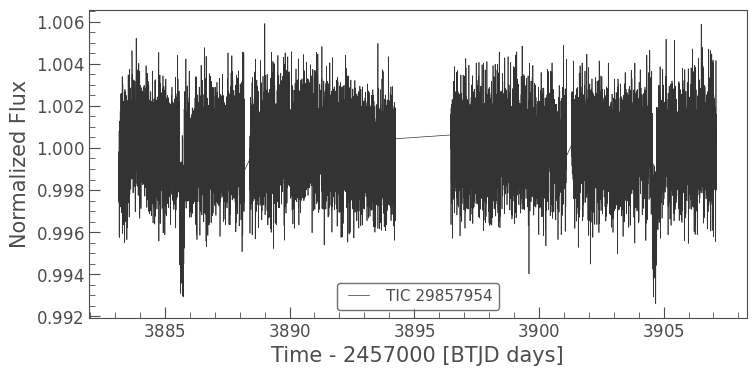

In [5]:
import final.get_data_from_id as get_data_from_id
import importlib
importlib.reload(get_data_from_id)
from final.get_data_from_id import download_all_sectors
data = download_all_sectors(29857954)
print(data.keys())
lc0 = data[(95, np.float64(120.0))]
lc0.plot()
plt.show()

/var/folders/jg/9yk8_v0s1qj6rnylv9ctc4gr0000gn/T/ipykernel_1793/2603986568.py:145: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [3:06:09<00:00,  3.72s/it, 575 steps of size 5.38e-05. acc. prob=0.68]      



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _b      0.61      0.12      0.61      0.49      0.74      1.00    154.34
      logD     -6.56      0.05     -6.55     -6.65     -6.50      6.90      1.42
      logP      2.14      0.06      2.14      2.08      2.20      1.00   2916.76
         r      0.01      0.00      0.01      0.01      0.01      1.01     11.08
        t0   3894.98      0.18   3894.98   3894.80   3895.17      1.00   1359.56
        u1      0.46      0.32      0.45      0.14      0.80      1.00     68.26
        u2      0.19      0.26      0.18     -0.08      0.46      1.00     92.52

Number of divergences: 0


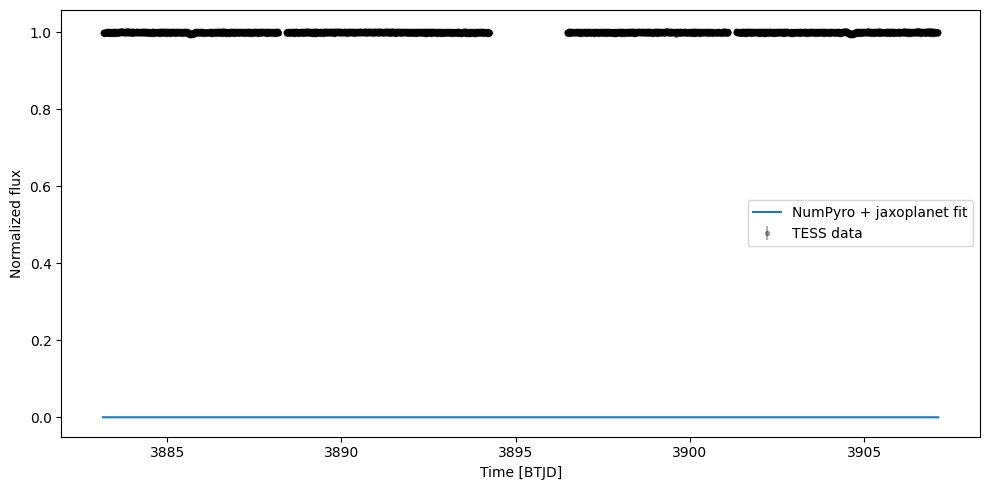

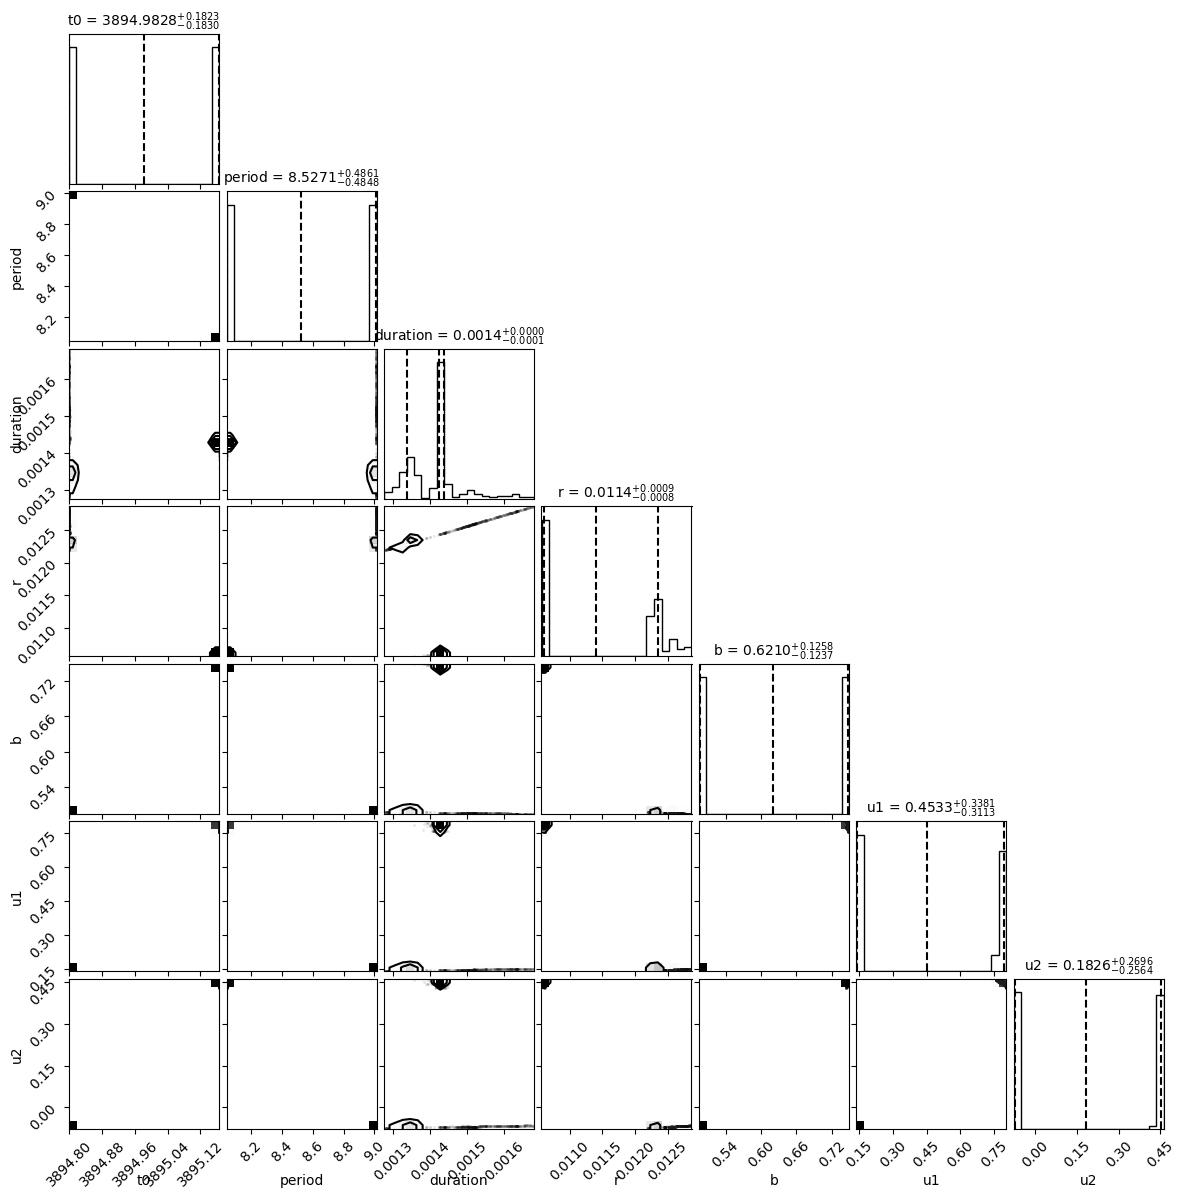

In [10]:
# =============================
# 0. 导入包 & 基本设置
# =============================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

import arviz as az
import corner

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")         # 你有 GPU 也可以改成 "gpu"
numpyro.set_host_device_count(2)    # 两个链并行


# =============================
# 1. 准备 TESS 某个 sector 的数据
# =============================
# 假设你已经有一个 LightCurve 对象 lc
# 比如：
#   from lightkurve import TessLightCurve
#   lc = sector_data[92]
# 这里我只写成一个占位变量，你直接用自己的 lc 替换这一行：
# -------------------------------------------------
# TODO: 替换成你自己的 lc，例如：
# lc = sector_data[92]
# -------------------------------------------------
# 为了避免报错，这里先写成 None，真正跑的时候记得改！
lc = lc0   # 确保上面那行你已经替换好了

# 提取时间、flux、误差
time_np = lc.time.value           # BTJD, unit: day
flux_np = lc.flux.value           # 已经 normalize 的光通量

if lc.flux_err is not None:
    flux_err_np = lc.flux_err.value
else:
    # 如果没有误差，就先用全局标准差粗略顶一下
    flux_err_np = np.full_like(flux_np, np.std(flux_np))

# 转成 JAX array
time = jnp.array(time_np)
flux = jnp.array(flux_np)
flux_err = jnp.array(flux_err_np)


# =============================
# 2. 给一个初始的参数猜测（很重要）
# =============================
# 你需要给定这个行星大概的：
#   - 周期 PERIOD_INIT（单位：天）
#   - 凌日持续时间 DURATION_INIT（可以粗略估）
#   - 某个参考凌日时间 T0_INIT（可以用中间某个 transit 附近的时间）
# 这几个可以来自文献 / MAST / 目测
# -------------------------------------------------
# TODO: 你自己改下面这三个数！
PERIOD_INIT   = 9.3      # 比如 4 天，只是示例
DURATION_INIT = 0.2      # 比如凌日持续 ~0.2 天
T0_INIT       = float(time_np.mean())  # 先用本 sector 中点，当参考凌日时间
# -------------------------------------------------


# =============================
# 3. 定义 jaxoplanet 的 light curve 模型
# =============================
def light_curve_model(time, params):
    """
    使用 jaxoplanet 计算给定参数下的 limb-darkened transit light curve。
    params 是一个 dict, 包含:
        - period
        - duration
        - t0
        - b
        - r
        - u: array([u1, u2])
    """
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(time)


# =============================
# 4. 定义 NumPyro 的贝叶斯模型
# =============================
def model(t, yerr, y=None):
    # t0: 参考凌日时间，以 T0_INIT 为中心，先给一个比较宽的先验
    t0 = numpyro.sample("t0", dist.Normal(T0_INIT, 1.0))

    # period: 在 log 空间采样，中心是 log(PERIOD_INIT)
    logP = numpyro.sample("logP", dist.Normal(jnp.log(PERIOD_INIT), 0.2))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # duration: 在 log 空间采样，中心是 log(DURATION_INIT)
    logD = numpyro.sample("logD", dist.Normal(jnp.log(DURATION_INIT), 0.3))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 半径比 r: 先用一个比较宽的 Uniform
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # impact parameter b: 限制在 0 ~ 1 + r
    _b = numpyro.sample("_b", dist.Uniform(0.0, 1.0))
    b = numpyro.deterministic("b", _b * (1.0 + r))

    # limb darkening: 简单给两个 Normal 先验
    u1 = numpyro.sample("u1", dist.Normal(0.3, 0.3))
    u2 = numpyro.sample("u2", dist.Normal(0.2, 0.3))
    u = jnp.array([u1, u2])

    # 计算模型光变
    y_model = light_curve_model(
        t,
        {"period": period, "duration": duration, "t0": t0, "b": b, "r": r, "u": u},
    )

    # 记录一下模型光变，方便后面取出来画图
    numpyro.deterministic("light_curve", y_model)

    # 高斯似然
    numpyro.sample("obs", dist.Normal(y_model, yerr), obs=y)


# =============================
# 5. 运行 NUTS MCMC 采样
# =============================
kernel = NUTS(
    model,
    dense_mass=True,
    regularize_mass_matrix=True,
    init_strategy=numpyro.infer.init_to_median(),
)

mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, time, flux_err, y=flux)
mcmc.print_summary()

samples = mcmc.get_samples()


# =============================
# 6. 用后验均值画一张拟合效果图
# =============================
t0_post       = np.mean(np.array(samples["t0"]))
period_post   = np.mean(np.array(samples["period"]))
duration_post = np.mean(np.array(samples["duration"]))
r_post        = np.mean(np.array(samples["r"]))
b_post        = np.mean(np.array(samples["b"]))
u1_post       = np.mean(np.array(samples["u1"]))
u2_post       = np.mean(np.array(samples["u2"]))
u_post        = jnp.array([u1_post, u2_post])

params_post = {
    "t0": t0_post,
    "period": period_post,
    "duration": duration_post,
    "r": r_post,
    "b": b_post,
    "u": u_post,
}

model_flux = light_curve_model(time, params_post)

plt.figure(figsize=(10, 5))
plt.errorbar(time_np, flux_np, flux_err_np, fmt=".k", alpha=0.3, label="TESS data")
plt.plot(time_np, np.array(model_flux), "-", label="NumPyro + jaxoplanet fit")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized flux")
plt.legend()
plt.tight_layout()
plt.show()


# =============================
# 7. 生成 ArviZ InferenceData & 画角图（corner plot）
# =============================
inf_data = az.from_numpyro(mcmc)

# 只选部分参数画角图（t0, period, duration, r, b, u）
# u 是二维参数，会显示成 u[0], u[1]
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u1", "u2"],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)
plt.show()


In [1]:
import lightkurve as lk

def download_all_sectors(tic_id, author="SPOC"):
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author=author)
    data = {}
    
    for row in search:
        # 有些 LightKurve 版本可以直接 row.sector；保险一点：
        mission_str = row.table["mission"][0]
        # "TESS Sector 92" -> 92
        sector_num = int(str(mission_str).split()[-1])

        print(f"Downloading TIC {tic_id} Sector {sector_num} ...")
        lc = (row
              .download(flux_column="pdcsap_flux")
              .remove_nans()
              .normalize())

        data[sector_num] = lc

    return data

tic_id = 29857954
sector_data = download_all_sectors(tic_id)
print(sector_data.keys())
# 举例：访问 Sector 92
lc92 = sector_data[92]


/opt/anaconda3/envs/proj_tess/lib/python3.11/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


dict_keys([28, 68, 92, 95])


/var/folders/jg/9yk8_v0s1qj6rnylv9ctc4gr0000gn/T/ipykernel_43929/640750062.py:149: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 2. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [04:47<00:00, 10.43it/s, 23 steps of size 5.64e-02. acc. prob=0.91]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _b      0.60      0.24      0.56      0.21      1.00     14.40      1.20
      logD     -4.09      2.49     -4.58     -6.69     -1.36      2.01     13.07
      logP      2.34      0.34      2.36      1.87      2.72      2.05      6.44
         r      0.08      0.09      0.01      0.01      0.24      3.06      1.68
        t0   3815.91      0.36   3815.93   3815.24   3816.51     11.96      1.12
        u1      0.45      0.35      0.32      0.02      0.93      3.14      1.66
        u2      0.23      0.27      0.19     -0.17      0.57      4.84      1.32

Number of divergences: 3779


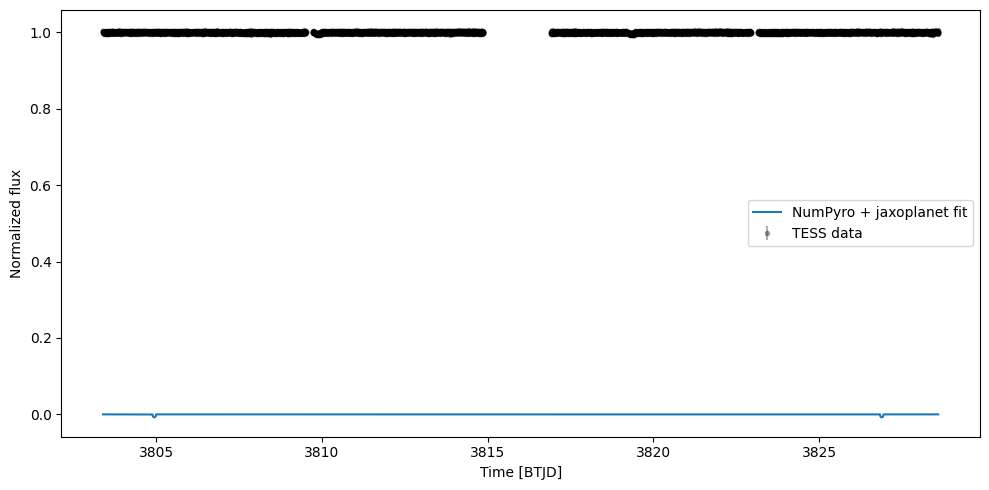

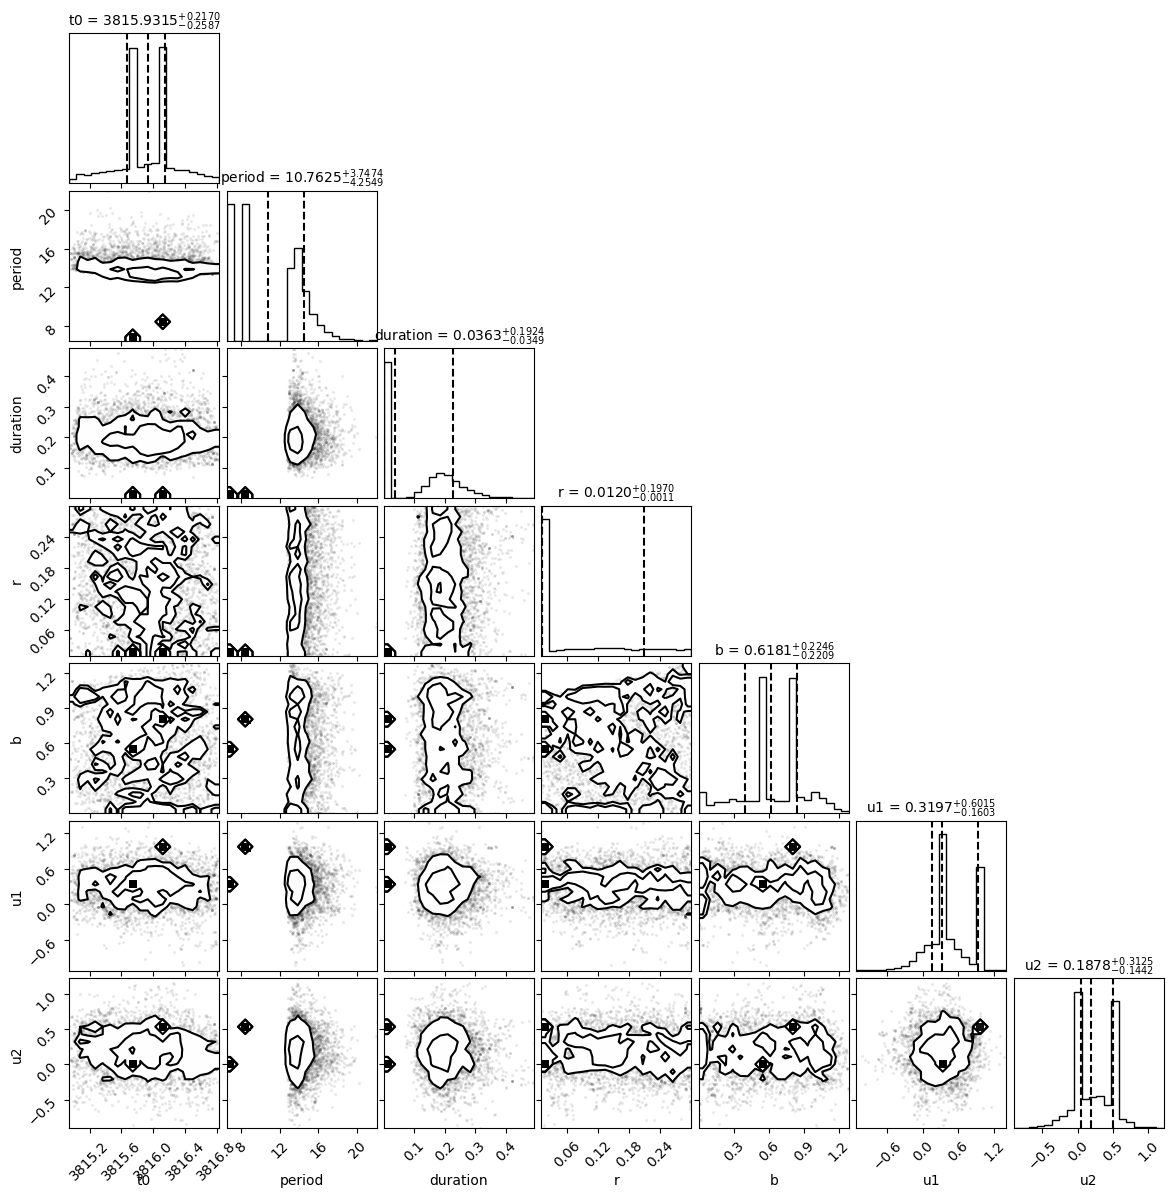

In [3]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

import arviz as az
import corner

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")          # 有 GPU 想用的话改成 "gpu"
numpyro.set_host_device_count(2)     # 两个链并行


# ============================================
# 1. 从你的 dict 中取一个 sector 的 LightCurve
# ============================================
# 假设你已经有 sector_data 这个 dict，
# 比如之前是：sector_data = download_all_sectors(tic_id)
# 这里我们就选 Sector 92 来拟合：

# 如果你的 key 是 92：
# lc = sector_data[92]

# 如果你的 key 是 (92, 158) 这种 (sector, exptime)：
# lc = sector_data[(92, 158)]

# 请根据你自己的 dict 改这一行 👇
lc = sector_data[92]   # TODO：如果你用的是 (92, 158)，就改成 sector_data[(92, 158)]

# 提取时间、flux、误差（全部用 numpy array）
time_np = lc.time.value          # BTJD, 单位：day
flux_np = lc.flux.value          # 已经 normalize 的光通量

if lc.flux_err is not None:
    flux_err_np = lc.flux_err.value
else:
    # 如果没有误差，就先用全局 std 粗略估计一个常数噪声
    flux_err_np = np.full_like(flux_np, np.std(flux_np))

# 转成 JAX array
time = jnp.array(time_np)
flux = jnp.array(flux_np)
flux_err = jnp.array(flux_err_np)


# ============================================
# 2. 给一个初始参数猜测（相当于你的“先验中心”）
#    这部分有点像你给的 PyMC 代码里 Uniform/Normal 那些先验
# ============================================
# 你需要自己给出这个行星的大概：
#   - PERIOD_INIT：轨道周期 [day]
#   - DURATION_INIT：凌日持续时间 [day]
#   - T0_INIT：某次凌日的参考时间 [BTJD]
# 可以先大概给一个，后面不满意再调。

# ======= 这三个一定要改成你自己的值！=======
PERIOD_INIT   = 9.7                 # TODO：这个行星的大概周期（天）
DURATION_INIT = 0.2                 # TODO：大概凌日持续时间（天）
T0_INIT       = float(time_np.mean())  # TODO：某次凌日中心，先用本 sector 中点占位
# ===========================================


# ============================================
# 3. jaxoplanet 的光变模型
#    （结构类似你 PyMC 里把参数塞进 RUWE() 那样）
# ============================================
def light_curve_model(t, params):
    """
    使用 jaxoplanet 计算 limb-darkened transit light curve.
    params: dict, 包含
        - period
        - duration
        - t0
        - b
        - r
        - u: array([u1, u2])
    """
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(t)


# ============================================
# 4. NumPyro 模型（对应你 PyMC 里的 build_model）
#    priors 的风格跟你给的 PyMC 类似：Uniform / Normal / log-space 等
# ============================================
def transit_model(t, yerr, y=None):
    # t0：以 T0_INIT 为中心，1 天的 Normal 先验
    t0 = numpyro.sample("t0", dist.Normal(T0_INIT, 1.0))

    # period：在 log 空间采样，正类似你 PyMC 里 log_a / log_m2 的写法
    logP = numpyro.sample("logP", dist.Normal(jnp.log(PERIOD_INIT), 0.2))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # duration：同样 log 空间
    logD = numpyro.sample("logD", dist.Normal(jnp.log(DURATION_INIT), 0.3))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 半径比 r：类似你用 Uniform 对 log_a 做边界，这里直接 Uniform 在[0.01, 0.3]
    r = numpyro.sample("r", dist.Uniform(0.01, 0.3))

    # impact parameter b：通过 _b Uniform(0,1) 再缩放到 [0, 1+r]
    _b = numpyro.sample("_b", dist.Uniform(0.0, 1.0))
    b = numpyro.deterministic("b", _b * (1.0 + r))

    # limb darkening：用两个 Normal 先验，类似给 ruwe sigma0 HalfNormal 的那种软约束
    u1 = numpyro.sample("u1", dist.Normal(0.3, 0.3))
    u2 = numpyro.sample("u2", dist.Normal(0.2, 0.3))
    u = jnp.array([u1, u2])

    # 用 jaxoplanet 算光变
    y_model = light_curve_model(
        t,
        {"period": period, "duration": duration, "t0": t0, "b": b, "r": r, "u": u},
    )

    # 把模型光变记录下来，方便后面画图
    numpyro.deterministic("light_curve", y_model)

    # 高斯似然（相当于你 PyMC 里那个 pm.Normal("ruwe_obs_like", ...)）
    numpyro.sample("obs", dist.Normal(y_model, yerr), obs=y)


# ============================================
# 5. 跑 NUTS MCMC
# ============================================
kernel = NUTS(
    transit_model,
    dense_mass=True,
    regularize_mass_matrix=True,
    init_strategy=numpyro.infer.init_to_median(),
)

mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, time, flux_err, y=flux)
mcmc.print_summary()     # 类似 pm.sample 返回的 summary

samples = mcmc.get_samples()


# ============================================
# 6. 用后验均值画一次拟合效果
# ============================================
t0_post       = np.mean(np.array(samples["t0"]))
period_post   = np.mean(np.array(samples["period"]))
duration_post = np.mean(np.array(samples["duration"]))
r_post        = np.mean(np.array(samples["r"]))
b_post        = np.mean(np.array(samples["b"]))
u1_post       = np.mean(np.array(samples["u1"]))
u2_post       = np.mean(np.array(samples["u2"]))
u_post        = jnp.array([u1_post, u2_post])

params_post = {
    "t0": t0_post,
    "period": period_post,
    "duration": duration_post,
    "r": r_post,
    "b": b_post,
    "u": u_post,
}

model_flux = light_curve_model(time, params_post)

plt.figure(figsize=(10, 5))
plt.errorbar(time_np, flux_np, flux_err_np, fmt=".k", alpha=0.3, label="TESS data")
plt.plot(time_np, np.array(model_flux), "-", label="NumPyro + jaxoplanet fit")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized flux")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================
# 7. 生成 ArviZ InferenceData & 画 corner plot（角图）
# ============================================
inf_data = az.from_numpyro(mcmc)

# 如果好奇有哪些变量，可以先看看：
# print(inf_data)
# print(inf_data.posterior.data_vars)

# 这里画 t0, period, duration, r, b, u1, u2 的角图
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u1", "u2"],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)
plt.show()


In [4]:
print(inf_data)
print(az.summary(inf_data, var_names=["t0", "period", "duration", "r", "b", "u1", "u2"]))


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
              mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t0        3815.915  0.357  3815.130  3816.599      0.071    0.058      29.0   
period      10.978  3.530     6.507    15.759      1.713    0.379       5.0   
duration     0.105  0.113     0.001     0.284      0.052    0.002       5.0   
r            0.084  0.093     0.011     0.264      0.037    0.007       5.0   
b            0.640  0.262     0.000     1.034      0.052    0.056      27.0   
u1           0.451  0.350    -0.091     0.925      0.136    0.048       8.0   
u2           0.230  0.268    -0.286     0.620      0.084    0.009      13.0   

          ess_tail  r_hat  
t0           128.0   1.11  
period        26.0   2.11  
duration      21.0   2.14  
r             27.0   2.08  
b             60.0   1.31  
u1            38.0   1.61  
u2           257.0   1.23  


Running chain 1: 100%|██████████| 3000/3000 [00:01<00:00, 2853.87it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.50      0.29      0.51      0.01      0.91   3781.43      1.00
         r      0.11      0.06      0.11      0.03      0.20   4115.95      1.00
        t0   3815.99      0.10   3815.99   3815.82   3816.15   4093.29      1.00

Number of divergences: 0


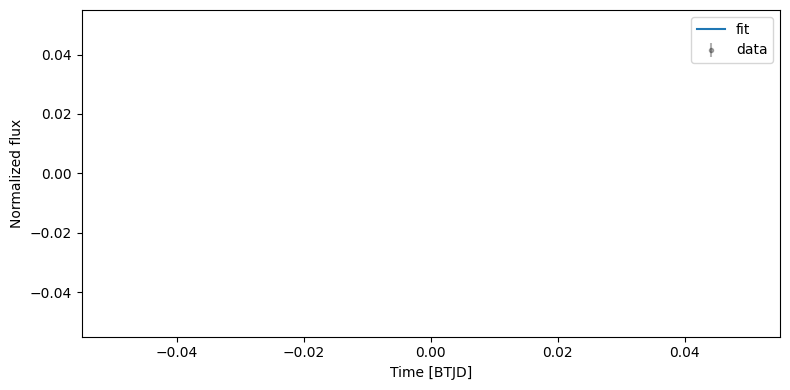

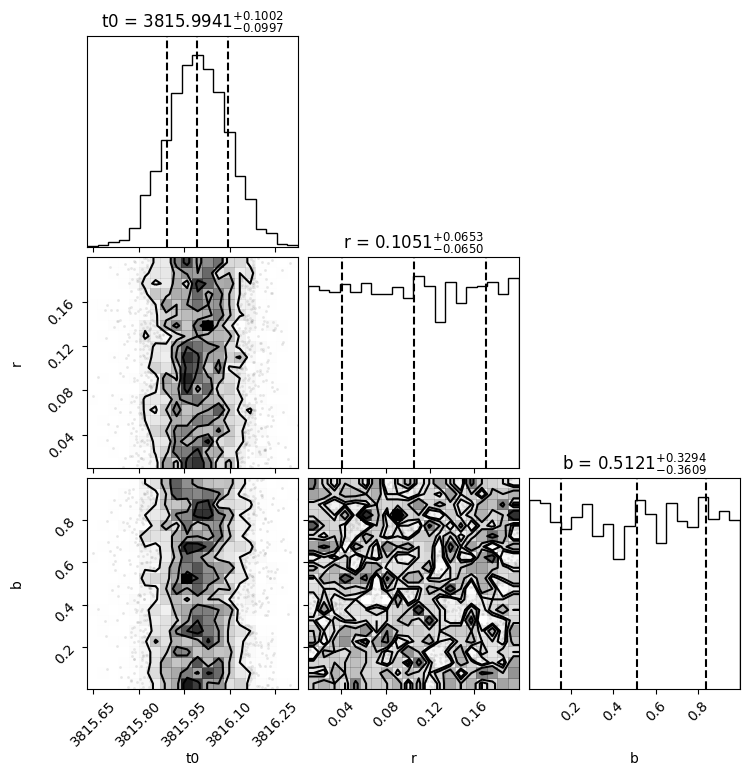

In [5]:
# ========= 简化版：只拟合 t0, r, b，period/duration/u 固定 =========

# 1. 先对时间做一个 window，只保留一小段有 transit 的数据
#    你可以把 t0_guess 改成你大概看到凌日中心的位置
t0_guess = T0_INIT   # 还是用前面那个，或者你目测的值
window = 0.5         # [day]，只取 t0±0.5 天的数据

mask = (time_np > t0_guess - window) & (time_np < t0_guess + window)
time_np_win = time_np[mask]
flux_np_win = flux_np[mask]
flux_err_np_win = flux_err_np[mask]

time_win = jnp.array(time_np_win)
flux_win = jnp.array(flux_np_win)
flux_err_win = jnp.array(flux_err_np_win)

# 2. 固定 period, duration, limb darkening:
PERIOD_FIXED   = PERIOD_INIT      # 用你已知的周期
DURATION_FIXED = DURATION_INIT    # 用你经验估的 duration
U_FIXED        = jnp.array([0.3, 0.2])  # 先随便给个，后面再精细

def light_curve_model_simple(t, t0, r, b):
    orbit = TransitOrbit(
        period=PERIOD_FIXED,
        duration=DURATION_FIXED,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    return limb_dark_light_curve(orbit, U_FIXED)(t)

def simple_model(t, yerr, y=None):
    # t0 在 window 中采样
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 0.1))

    # r 较小范围
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # b 限制 0~1：不做 (1+r) 缩放，直接 Uniform
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    y_model = light_curve_model_simple(t, t0, r, b)
    numpyro.deterministic("light_curve", y_model)

    numpyro.sample("obs", dist.Normal(y_model, yerr), obs=y)

# 3. 跑 MCMC
kernel = NUTS(simple_model,
              dense_mass=True,
              regularize_mass_matrix=True,
              init_strategy=numpyro.infer.init_to_median())

mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, time_win, flux_err_win, y=flux_win)
mcmc.print_summary()

samples = mcmc.get_samples()

# 4. 画拟合效果（只在 window 里）
t0_post = np.mean(np.array(samples["t0"]))
r_post  = np.mean(np.array(samples["r"]))
b_post  = np.mean(np.array(samples["b"]))

model_flux_win = light_curve_model_simple(time_win, t0_post, r_post, b_post)

plt.figure(figsize=(8, 4))
plt.errorbar(time_np_win, flux_np_win, flux_err_np_win, fmt=".k", alpha=0.3, label="data")
plt.plot(time_np_win, np.array(model_flux_win), "-", label="fit")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized flux")
plt.legend()
plt.tight_layout()
plt.show()

# 5. 画角图（现在参数只有 3 个，应该很稳）
inf_data = az.from_numpyro(mcmc)

flat_samples = {
    "t0": inf_data.posterior["t0"].values.reshape(-1),
    "r":  inf_data.posterior["r"].values.reshape(-1),
    "b":  inf_data.posterior["b"].values.reshape(-1),
}

fig = plt.figure(figsize=(8, 8))
_ = corner.corner(
    flat_samples,
    labels=["t0", "r", "b"],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
    fig=fig,
)
plt.show()


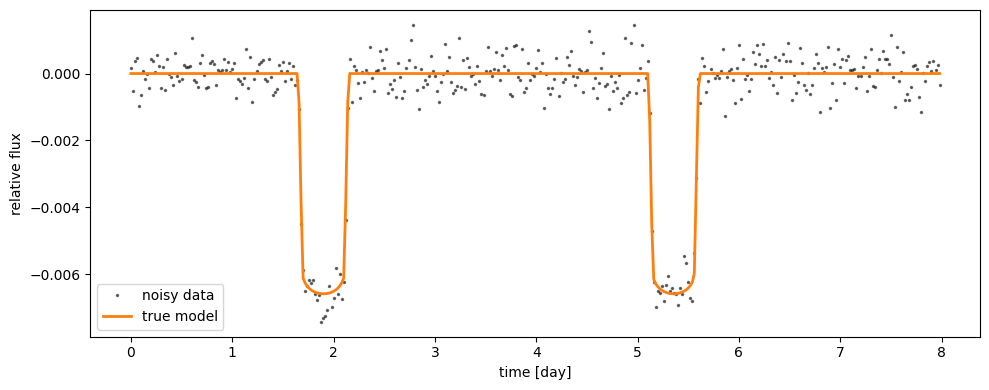

sample: 100%|██████████| 3000/3000 [00:19<00:00, 151.56it/s, 31 steps of size 1.26e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _b      0.37      0.16      0.41      0.12      0.61    346.31      1.00
      logD     -0.69      0.01     -0.70     -0.71     -0.68    586.06      1.00
      logP      1.24      0.00      1.24      1.24      1.24   2491.11      1.00
         r      0.08      0.00      0.08      0.08      0.08    610.96      1.00
        t0      1.90      0.00      1.90      1.90      1.90   2411.41      1.00
        u1      0.14      0.16      0.14     -0.11      0.42    968.22      1.00
        u2      0.01      0.24      0.01     -0.38      0.41    977.45      1.00

Number of divergences: 0


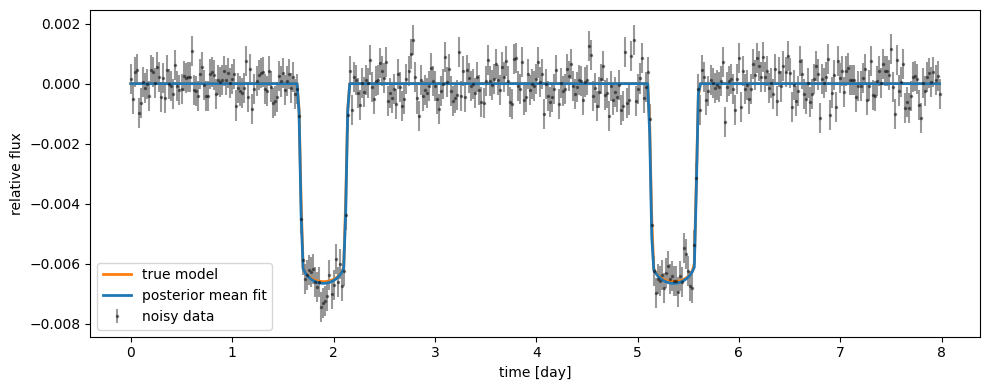

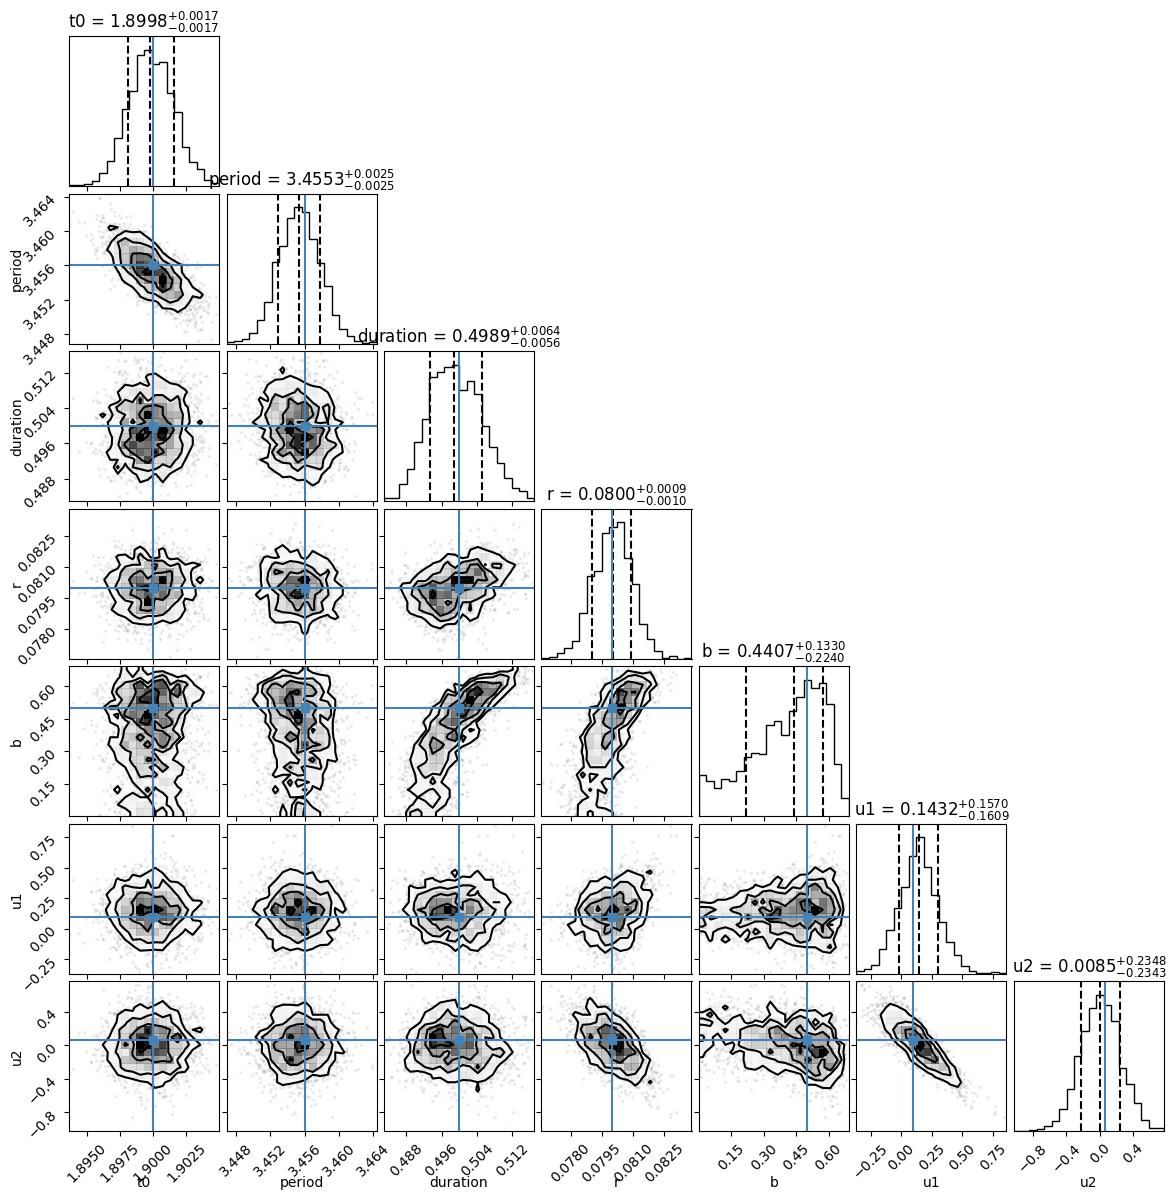

In [6]:
# ============================================
# 0. 导入依赖 & JAX 设置
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

import arviz as az
import corner

# 用 double 精度
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")      # 有 GPU 想玩可以改成 "gpu"


# ============================================
# 1. 用 jaxoplanet 生成模拟光变（两次凌日）
# ============================================

# ---- 真值（True parameters）----
PERIOD_TRUE   = 3.456      # [day] 轨道周期
T0_TRUE       = 1.9        # [day] 首次凌日中心时间
DURATION_TRUE = 0.5        # [day] 凌日持续时间
B_TRUE        = 0.5        # impact parameter
R_TRUE        = 0.08       # Rp/Rs
U_TRUE        = jnp.array([0.1, 0.06])  # limb darkening (quadratic)

# 噪声水平（标准差）
YERR_TRUE = 5e-4            # 相当于 500 ppm

# ---- 生成时间轴：保证有至少两次 transit ----
# 从 t=0 到 t=8 天，每 0.02 天一个点
time_np = np.arange(0.0, 8.0, 0.02)
time = jnp.array(time_np)

# ---- 用 jaxoplanet 生成无噪声的光变 ----
orbit_true = TransitOrbit(
    period=PERIOD_TRUE,
    duration=DURATION_TRUE,
    time_transit=T0_TRUE,
    impact_param=B_TRUE,
    radius_ratio=R_TRUE,
)

flux_true = limb_dark_light_curve(orbit_true, U_TRUE)(time)

# ---- 加高斯噪声 ----
rng = np.random.default_rng(42)
noise = YERR_TRUE * rng.normal(size=time_np.size)
flux_np = np.array(flux_true) + noise
flux_err_np = np.full_like(flux_np, YERR_TRUE)

# 画一下模拟数据
plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=3, alpha=0.5, label="noisy data")
plt.plot(time_np, np.array(flux_true), "-C1", lw=2, label="true model")
plt.xlabel("time [day]")
plt.ylabel("relative flux")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================
# 2. 定义 jaxoplanet 光变模型（和上面一样，只是参数变成变量）
# ============================================
def light_curve_model(time, params):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(time)


# ============================================
# 3. NumPyro 模型：用来拟合我们刚刚模拟的光变
# ============================================
def transit_model(t, yerr, y=None):
    """
    拟合参数：
      t0, period, duration, r, b, u1, u2
    先验大体参考 jaxoplanet 官方教程 + 你的 PyMC 风格
    """
    # t0：以 true 值附近为中心，给宽一点的 Normal 先验
    t0 = numpyro.sample("t0", dist.Normal(T0_TRUE, 1.0))

    # period：log 空间先验，中心是 log(PERIOD_TRUE)
    logP = numpyro.sample("logP", dist.Normal(jnp.log(PERIOD_TRUE), 0.2))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # duration：log 空间先验
    logD = numpyro.sample("logD", dist.Normal(jnp.log(DURATION_TRUE), 0.3))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 半径比 r：Uniform 先验
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # impact parameter b：通过 _b 缩放到 [0, 1 + r]
    _b = numpyro.sample("_b", dist.Uniform(0.0, 1.0))
    b = numpyro.deterministic("b", _b * (1.0 + r))

    # limb darkening：两个 Normal 先验
    u1 = numpyro.sample("u1", dist.Normal(0.1, 0.3))
    u2 = numpyro.sample("u2", dist.Normal(0.06, 0.3))
    u = jnp.array([u1, u2])

    # jaxoplanet 计算光变
    y_model = light_curve_model(
        t,
        {"period": period, "duration": duration, "t0": t0, "b": b, "r": r, "u": u},
    )

    numpyro.deterministic("light_curve", y_model)

    # 高斯似然
    numpyro.sample("obs", dist.Normal(y_model, yerr), obs=y)


# ============================================
# 4. 跑 NUTS MCMC 拟合人造数据
# ============================================
# 为了不让你的 Mac 风扇爆炸，先用 1 条链就好
kernel = NUTS(
    transit_model,
    dense_mass=True,
    regularize_mass_matrix=True,
    init_strategy=numpyro.infer.init_to_median(),
)

mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,        # 先 1 条链，稳定后你再改成 2
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, time, flux_err_np, y=flux_np)
mcmc.print_summary()

samples = mcmc.get_samples()


# ============================================
# 5. 用后验均值画 fit 和角图
# ============================================

# ---- 拿 posterior 的均值当 "best fit" ----
t0_post       = np.mean(np.array(samples["t0"]))
period_post   = np.mean(np.array(samples["period"]))
duration_post = np.mean(np.array(samples["duration"]))
r_post        = np.mean(np.array(samples["r"]))
b_post        = np.mean(np.array(samples["b"]))
u1_post       = np.mean(np.array(samples["u1"]))
u2_post       = np.mean(np.array(samples["u2"]))
u_post        = jnp.array([u1_post, u2_post])

params_post = {
    "t0": t0_post,
    "period": period_post,
    "duration": duration_post,
    "r": r_post,
    "b": b_post,
    "u": u_post,
}

flux_model_post = light_curve_model(time, params_post)

# ---- 画拟合效果 ----
plt.figure(figsize=(10, 4))
plt.errorbar(time_np, flux_np, flux_err_np, fmt=".k", ms=3, alpha=0.4, label="noisy data")
plt.plot(time_np, np.array(flux_true), "-C1", lw=2, label="true model")
plt.plot(time_np, np.array(flux_model_post), "-C0", lw=2, label="posterior mean fit")
plt.xlabel("time [day]")
plt.ylabel("relative flux")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 角图（corner plot）----
inf_data = az.from_numpyro(mcmc)

# 把样本 flatten 成 dict，交给 corner
var_names = ["t0", "period", "duration", "r", "b", "u1", "u2"]
flat_samples = {
    v: inf_data.posterior[v].values.reshape(-1)
    for v in var_names
}

fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    flat_samples,
    labels=var_names,
    truths=[T0_TRUE, PERIOD_TRUE, DURATION_TRUE, R_TRUE, B_TRUE, U_TRUE[0], U_TRUE[1]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
    fig=fig,
)
plt.show()


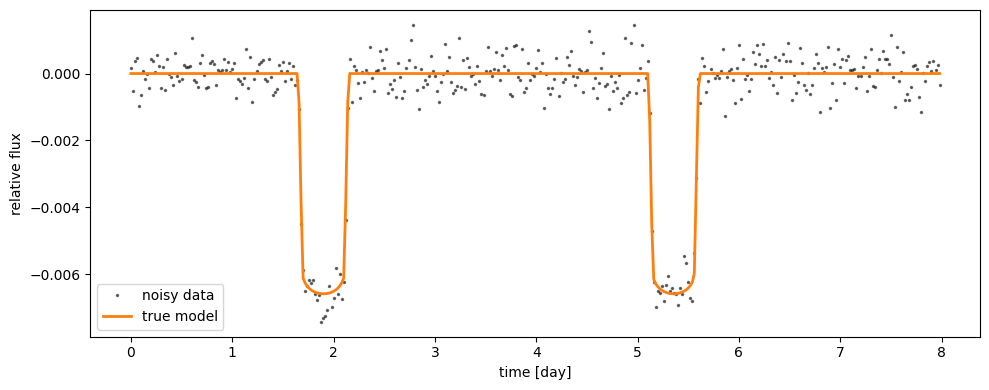

sample: 100%|██████████| 3000/3000 [00:20<00:00, 146.82it/s, 47 steps of size 1.30e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b_raw     -0.01      0.34     -0.01     -0.51      0.50    390.56      1.00
      logD     -0.70      0.01     -0.70     -0.71     -0.68    908.93      1.00
      logP      1.24      0.00      1.24      1.24      1.24   2310.75      1.00
         r      0.08      0.00      0.08      0.08      0.08    918.92      1.00
        t0      5.36      0.00      5.36      5.35      5.36   2281.83      1.00
        u1      0.12      0.06      0.12      0.02      0.22    815.53      1.00
        u2      0.19      0.11      0.17      0.02      0.34    815.98      1.00

Number of divergences: 0


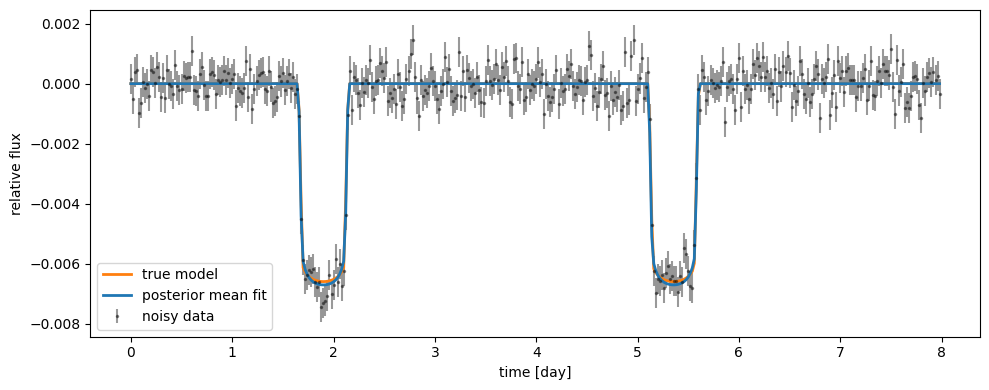

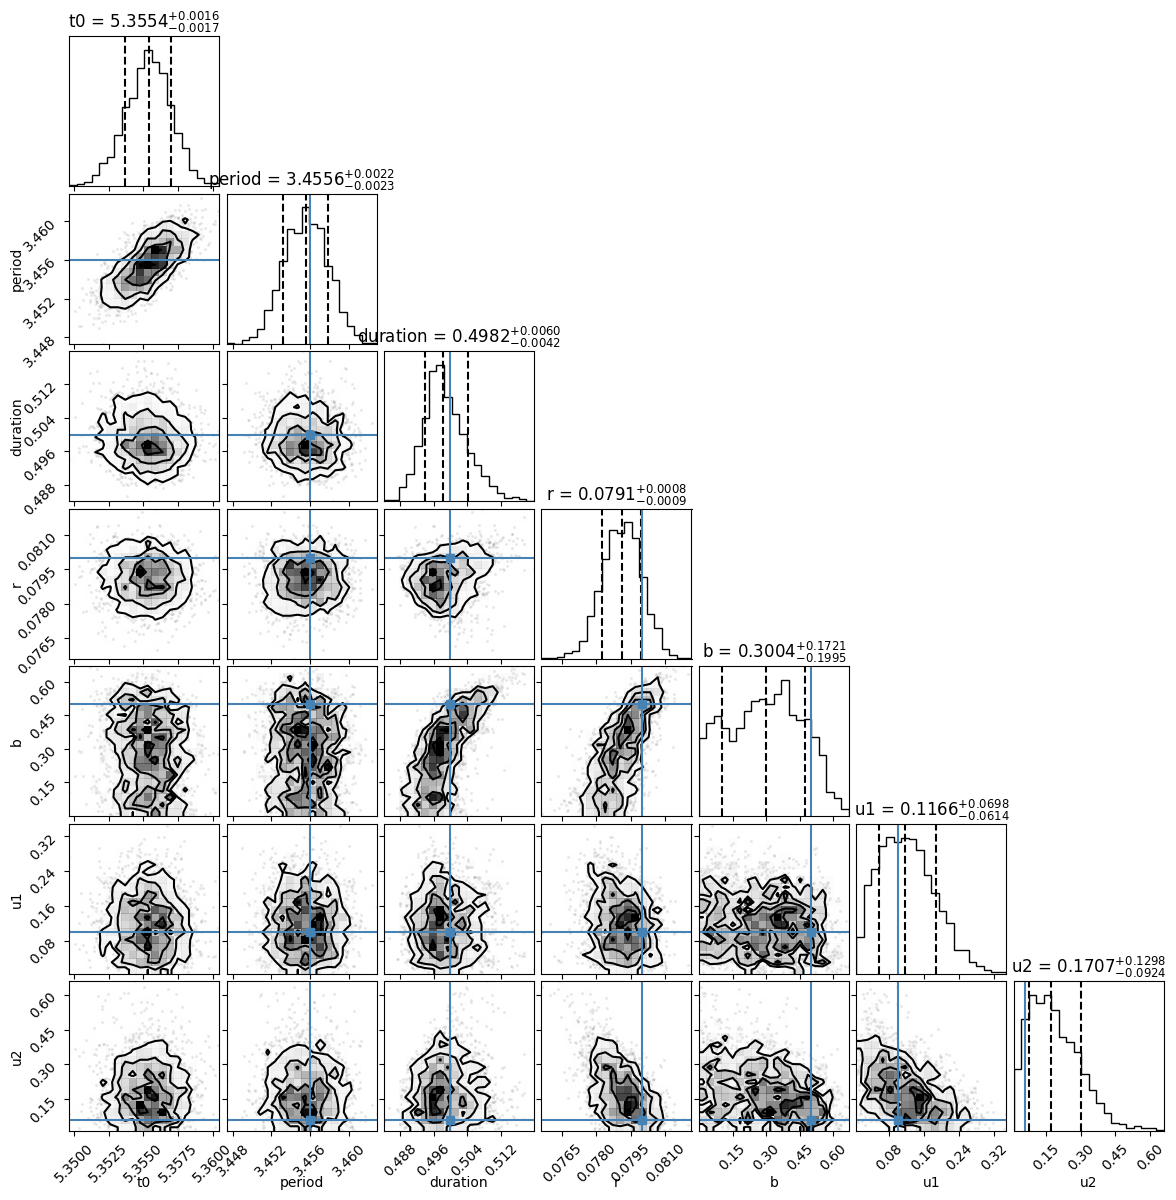

In [12]:
# ============================================
# 0. 导入依赖 & JAX 设置
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

import arviz as az
import corner

# 用 double 精度
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")      # 有 GPU 想玩可以改成 "gpu"


# ============================================
# 1. 用 jaxoplanet 生成模拟光变（两次凌日）
# ============================================

# ---- 真值（True parameters）----
PERIOD_TRUE   = 3.456      # [day] 轨道周期
T0_TRUE       = 1.9        # [day] 首次凌日中心时间
DURATION_TRUE = 0.5        # [day] 凌日持续时间
B_TRUE        = 0.5        # impact parameter
R_TRUE        = 0.08       # Rp/Rs
U_TRUE        = jnp.array([0.1, 0.06])  # limb darkening (quadratic)

# 噪声水平（标准差）
YERR_TRUE = 5e-4            # 相当于 500 ppm

# ---- 生成时间轴：保证有至少两次 transit ----
# 从 t=0 到 t=8 天，每 0.02 天一个点
time_np = np.arange(0.0, 8.0, 0.02)
time = jnp.array(time_np)

# ---- 用 jaxoplanet 生成无噪声的光变 ----
orbit_true = TransitOrbit(
    period=PERIOD_TRUE,
    duration=DURATION_TRUE,
    time_transit=T0_TRUE,
    impact_param=B_TRUE,
    radius_ratio=R_TRUE,
)

flux_true = limb_dark_light_curve(orbit_true, U_TRUE)(time)

# ---- 加高斯噪声 ----
rng = np.random.default_rng(42)
noise = YERR_TRUE * rng.normal(size=time_np.size)
flux_np = np.array(flux_true) + noise
flux_err_np = np.full_like(flux_np, YERR_TRUE)

# 画一下模拟数据
plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=3, alpha=0.5, label="noisy data")
plt.plot(time_np, np.array(flux_true), "-C1", lw=2, label="true model")
plt.xlabel("time [day]")
plt.ylabel("relative flux")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================
# 2. 定义 jaxoplanet 光变模型（和上面一样，只是参数变成变量）
# ============================================
def light_curve_model(time, params):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(time)


# ============================================
# 3. NumPyro 模型：使用 Gaia/PyMC 风格的先验
# ============================================
def transit_model(t, yerr, y=None):
    """
    改动点：
      ✔ t0 用宽 Uniform 或 Normal 都可，这里我们用 Uniform
      ✔ period 使用 log-uniform（仿 log_a）
      ✔ duration 使用 log-uniform（仿 logD）
      ✔ r 使用 HalfNormal（你 PyMC 里的风格）
      ✔ b 使用 Uniform(-1,1) 再 abs
      ✔ u1, u2 使用 Beta(2,2)
    """

    # ======== t0：让它自由一些 ========
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10.0))

    # ======== period：log-uniform ========
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(0.5), jnp.log(10.0)))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # ======== duration：log-uniform ========
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(2.0)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # ======== r：HalfNormal（更符合物理）=======
    r = numpyro.sample("r", dist.HalfNormal(0.1))

    # ======== impact parameter b ========
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # ======== Limb darkening：Beta(2,2) ========
    u1 = numpyro.sample("u1", dist.Beta(2, 2))
    u2 = numpyro.sample("u2", dist.Beta(2, 2))
    u = jnp.array([u1, u2])

    # ======== jaxoplanet 计算光变 ========
    y_model = light_curve_model(
        t,
        {
            "period": period,
            "duration": duration,
            "t0": t0,
            "b": b,
            "r": r,
            "u": u,
        },
    )

    numpyro.deterministic("light_curve", y_model)

    # ======== 高斯似然 ========
    numpyro.sample("obs", dist.Normal(y_model, yerr), obs=y)



# ============================================
# 4. 跑 NUTS MCMC 拟合人造数据
# ============================================
# 为了不让你的 Mac 风扇爆炸，先用 1 条链就好
kernel = NUTS(
    transit_model,
    dense_mass=True,
    regularize_mass_matrix=True,
    init_strategy=numpyro.infer.init_to_median(),
)

mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,        # 先 1 条链，稳定后你再改成 2
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, time, flux_err_np, y=flux_np)
mcmc.print_summary()

samples = mcmc.get_samples()


# ============================================
# 5. 用后验均值画 fit 和角图
# ============================================

# ---- 拿 posterior 的均值当 "best fit" ----
t0_post       = np.mean(np.array(samples["t0"]))
period_post   = np.mean(np.array(samples["period"]))
duration_post = np.mean(np.array(samples["duration"]))
r_post        = np.mean(np.array(samples["r"]))
b_post        = np.mean(np.array(samples["b"]))
u1_post       = np.mean(np.array(samples["u1"]))
u2_post       = np.mean(np.array(samples["u2"]))
u_post        = jnp.array([u1_post, u2_post])

params_post = {
    "t0": t0_post,
    "period": period_post,
    "duration": duration_post,
    "r": r_post,
    "b": b_post,
    "u": u_post,
}

flux_model_post = light_curve_model(time, params_post)

# ---- 画拟合效果 ----
plt.figure(figsize=(10, 4))
plt.errorbar(time_np, flux_np, flux_err_np, fmt=".k", ms=3, alpha=0.4, label="noisy data")
plt.plot(time_np, np.array(flux_true), "-C1", lw=2, label="true model")
plt.plot(time_np, np.array(flux_model_post), "-C0", lw=2, label="posterior mean fit")
plt.xlabel("time [day]")
plt.ylabel("relative flux")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 角图（corner plot）----
inf_data = az.from_numpyro(mcmc)

# 把样本 flatten 成 dict，交给 corner
var_names = ["t0", "period", "duration", "r", "b", "u1", "u2"]
flat_samples = {
    v: inf_data.posterior[v].values.reshape(-1)
    for v in var_names
}

fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    flat_samples,
    labels=var_names,
    truths=[T0_TRUE, PERIOD_TRUE, DURATION_TRUE, R_TRUE, B_TRUE, U_TRUE[0], U_TRUE[1]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
    fig=fig,
)
plt.show()


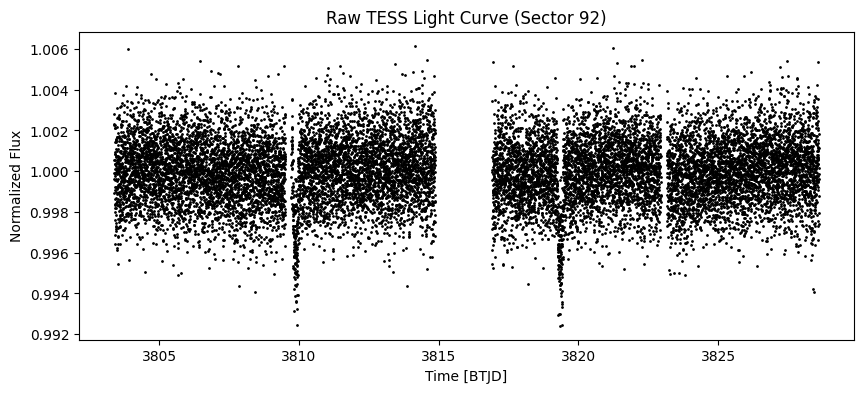

warmup:   7%|▋         | 214/3200 [03:36<50:19,  1.01s/it, 1023 steps of size 4.18e-04. acc. prob=0.76]  


KeyboardInterrupt: 

In [13]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

import arviz as az
import corner

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")
numpyro.set_host_device_count(2)


# ============================================
# 1. 取一个真实 TESS sector 的 LightCurve
# ============================================

# ⚠️ 你要确保这个 key 是你 dict 中的正确 key！
lc = sector_data[92]
# 如果你的 key 是 (92,120.0)，请写：
# lc = sector_data[(92,120.0)]

# ---- 转成 numpy ----
time_np = lc.time.value           # BTJD
flux_np = lc.flux.value           # normalized flux
if lc.flux_err is not None:
    flux_err_np = lc.flux_err.value
else:
    # 没有误差就先假设为全局 std
    flux_err_np = np.ones_like(flux_np) * np.std(flux_np)

# 转成 JAX array
time = jnp.array(time_np)
flux = jnp.array(flux_np)
flux_err = jnp.array(flux_err_np)

# 画一下真实数据
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.show()


# ============================================
# 2. jaxoplanet 光变模型
# ============================================
def light_curve_model(time, params):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(time)


# ============================================
# 3. NumPyro 模型：用于 TESS 实际拟合
# ============================================
def transit_model(t, yerr, y=None):

    # t0：我们让它在整个时间范围里自由找
    t0 = numpyro.sample("t0", dist.Uniform(time.min(), time.max()))

    # period：log-uniform
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(0.5), jnp.log(20.0)))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # duration：log-uniform
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(1.5)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # r：HalfNormal
    r = numpyro.sample("r", dist.HalfNormal(0.1))

    # b：Uniform(-1,1) → abs
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Beta(2, 2))
    u2 = numpyro.sample("u2", dist.Beta(2, 2))
    u = jnp.array([u1, u2])

    # 计算光变
    y_model = light_curve_model(
        t,
        {
            "period": period,
            "duration": duration,
            "t0": t0,
            "b": b,
            "r": r,
            "u": u,
        },
    )

    numpyro.deterministic("light_curve", y_model)

    numpyro.sample("obs", dist.Normal(y_model, yerr), obs=y)


# ============================================
# 4. NUTS MCMC
# ============================================
kernel = NUTS(
    transit_model,
    dense_mass=True,
    regularize_mass_matrix=True,
    init_strategy=numpyro.infer.init_to_median(),
)

mcmc = MCMC(
    kernel,
    num_warmup=1200,
    num_samples=2000,
    num_chains=1,   # 真实数据首次拟合，用 1 链更稳定
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, time, flux_err, y=flux)
mcmc.print_summary()

samples = mcmc.get_samples()


# ============================================
# 5. Posterior 拟合图
# ============================================
t0_post       = np.mean(np.array(samples["t0"]))
period_post   = np.mean(np.array(samples["period"]))
duration_post = np.mean(np.array(samples["duration"]))
r_post        = np.mean(np.array(samples["r"]))
b_post        = np.mean(np.array(samples["b"]))
u1_post       = np.mean(np.array(samples["u1"]))
u2_post       = np.mean(np.array(samples["u2"]))
u_post        = jnp.array([u1_post, u2_post])

params_post = {
    "t0": t0_post,
    "period": period_post,
    "duration": duration_post,
    "r": r_post,
    "b": b_post,
    "u": u_post,
}

flux_model_post = light_curve_model(time, params_post)

plt.figure(figsize=(10,4))
plt.errorbar(time_np, flux_np, flux_err_np, fmt=".k", ms=2, alpha=0.4, label="data")
plt.plot(time_np, np.array(flux_model_post), "-C1", lw=2, label="Posterior Model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Flux")
plt.title("Best-fit Transit Model (TESS Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================
# 6. 角图
# ============================================
inf_data = az.from_numpyro(mcmc)

var_names = ["t0", "period", "duration", "r", "b", "u1", "u2"]
flat_samples = {v: inf_data.posterior[v].values.reshape(-1) for v in var_names}

fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    flat_samples,
    labels=var_names,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
    fig=fig,
)
plt.show()


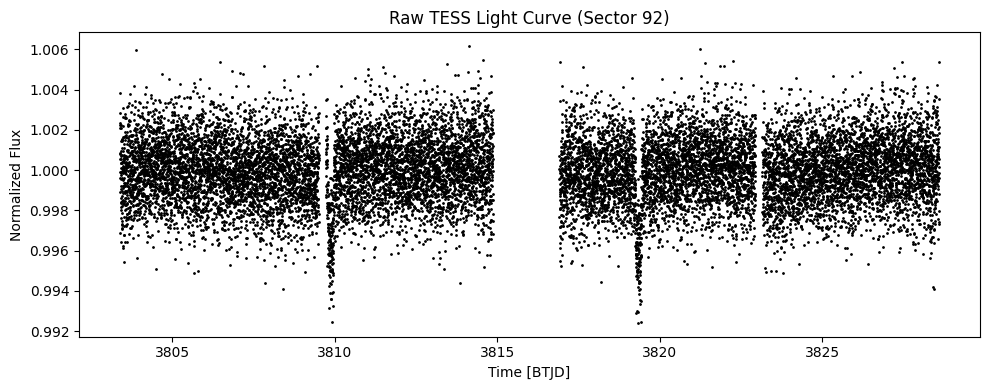

sigma = 0.0016291119391098619 prominence min = 0.0048873358173295856
找到的候选谷值个数: 42
候选时间: [3803.50866037 3803.93648095 3804.48931425 3805.09770852 3805.65331938
 3806.20754082 3806.77981917 3807.26319958 3807.86603563 3808.42025545
 3809.09531968 3809.91484133 3810.35238222 3810.85381767 3811.29552511
 3811.73167624 3812.37479039 3812.82899814 3813.35404536 3813.85409006
 3814.57915457 3817.07104834 3817.60998851 3818.20865659 3818.71564901
 3819.34209668 3819.94354142 3820.42414118 3820.84779095 3821.62147191
 3822.35070354 3823.28134079 3823.79805222 3824.28559408 3824.84397489
 3825.26206567 3825.74682839 3826.39966012 3826.88581098 3827.36501649
 3827.8720017  3828.43176865]


KeyError: 'prominence'

In [18]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


# ============================================
# 1. 取出 Sector 92 的真实光变
#    如果你的 key 是 (92,120.0) 请改这里
# ============================================
lc = sector_data[92]

time_np = lc.time.value          # BTJD
flux_np = lc.flux.value          # normalized flux

# 画一下整体光变
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()


# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
# 因为 flux ~ 1，直接做 inv_flux = 1 - flux
# --------------------------------------------
# 找两个最明显的 transit 谷值
# --------------------------------------------
inv_flux = 1.0 - flux_np

# std 一定转成 float，避免 array 类型传进 prominence
sigma = float(np.std(flux_np))
prom_min = 3.0 * sigma

print("sigma =", sigma, "prominence min =", prom_min)

from scipy.signal import find_peaks

peaks, props = find_peaks(
    inv_flux,
    distance=300,         # 两个 transit 至少间隔这么多点
    prominence=prom_min   # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])


# 取 prominence 最大的两个
order = np.argsort(props["prominence"])[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化看一下是不是两个真正的 transit
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.15):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    # 简单噪声估计
    sigma = np.std(f_cut)
    e_cut = np.ones_like(f_cut) * sigma
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.15)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.15)

# 看一下两个窗口
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


# ============================================
# 4. 只拟合 t0 + duration 的局部 transit 模型
#    r, b, limb darkening 固定成合理值
# ============================================
def transit_model_local(t, yerr, y=None):
    """
    局部拟合单次凌日：
      - 自由参数：t0, duration
      - 固定：r, b, u
    """

    # t0 以当前窗口平均时间为中心，宽度 ~0.05 天（约 1.2 小时）
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    # duration 用 log-uniform 先验，范围 [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 固定 shape 参数（你以后可以用全局拟合结果来替代）
    r = 0.08
    b = 0.5
    u = jnp.array([0.1, 0.06])

    orbit = TransitOrbit(
        period=10.0,          # dummy，不影响局部形状
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    model = limb_dark_light_curve(orbit, u)(t)

    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


# ============================================
# 5. 一个小函数：给一段光变，返回 t0 的后验均值
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=800, num_samples=1500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())
    return t0_mean, t0_std, samples


# ============================================
# 6. 分别拟合两次 transit 的中心时间
# ============================================
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")

# 也可以画一下每次拟合的局部结果
def plot_fit(time_array, flux_array, t0, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    # 用后验均值画一条 model 曲线
    D_post = float(np.mean(np.array(samples["duration"])))
    r = 0.08
    b = 0.5
    u = jnp.array([0.1, 0.06])

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    model = np.array(limb_dark_light_curve(orbit, u)(t))

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array, yerr=np.std(flux_array), fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")


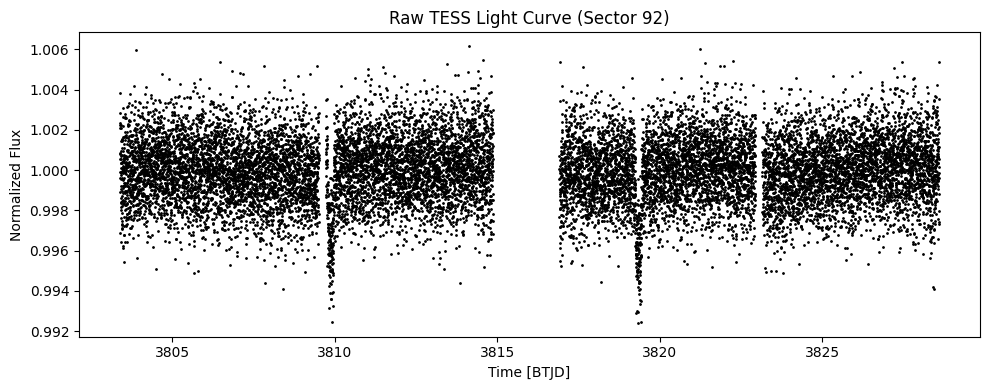

sigma = 0.0016291119391098619 prominence min = 0.0048873358173295856
找到的候选谷值个数: 42
候选时间: [3803.50866037 3803.93648095 3804.48931425 3805.09770852 3805.65331938
 3806.20754082 3806.77981917 3807.26319958 3807.86603563 3808.42025545
 3809.09531968 3809.91484133 3810.35238222 3810.85381767 3811.29552511
 3811.73167624 3812.37479039 3812.82899814 3813.35404536 3813.85409006
 3814.57915457 3817.07104834 3817.60998851 3818.20865659 3818.71564901
 3819.34209668 3819.94354142 3820.42414118 3820.84779095 3821.62147191
 3822.35070354 3823.28134079 3823.79805222 3824.28559408 3824.84397489
 3825.26206567 3825.74682839 3826.39966012 3826.88581098 3827.36501649
 3827.8720017  3828.43176865]
Transit candidates: 3809.9148413333896 3819.342096677204


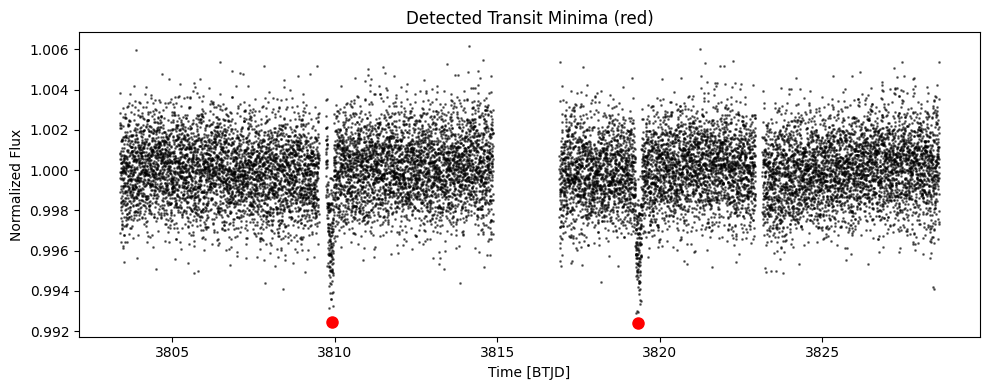

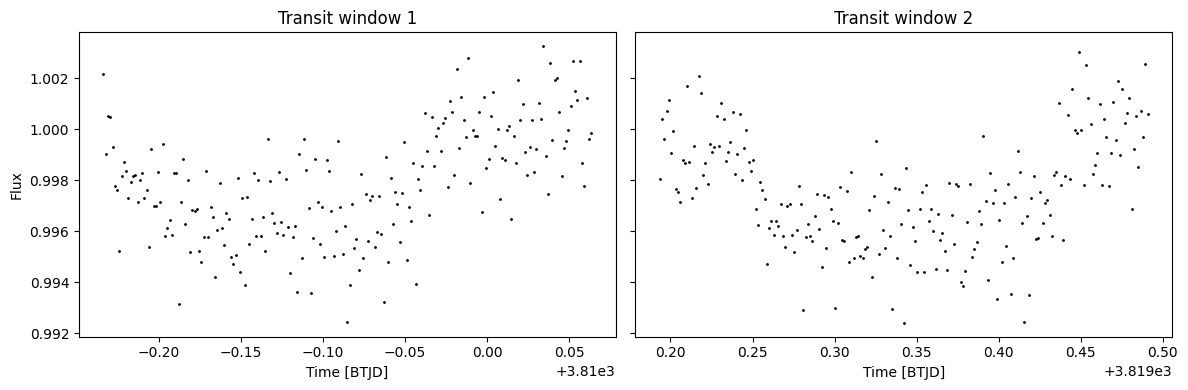

sample: 100%|██████████| 4000/4000 [00:12<00:00, 313.05it/s, 5 steps of size 7.61e-02. acc. prob=0.85]  

Transit 1 center time: 3810.111106 ± 0.014696
Transit 2 center time: 3819.538200 ± 0.016612
Difference (approx period): 9.427094 days


In [20]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


# ============================================
# 1. 取出 Sector 92 的真实光变
# ============================================
lc = sector_data[92]          # 如果你用的是 (92,120.0)，改这里

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()


# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma = float(np.std(flux_np))      # 一定转成 float
prom_min = 3.0 * sigma

print("sigma =", sigma, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,         # 两个 transit 至少隔这么多点
    prominence=prom_min   # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，可以自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（注意键叫 "prominences"）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化检查
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.15):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.15)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.15)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


# ============================================
# 4. 只拟合 t0 + duration 的局部 transit 模型
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以窗口平均时间为中心，宽度 ~0.05 天
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    # duration：log-uniform 先验
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 固定形状参数（以后可以用全局拟合的结果替换）
    r = 0.08
    b = 0.5
    u = jnp.array([0.1, 0.06])

    orbit = TransitOrbit(
        period=10.0,          # dummy，不影响局部形状
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    model = limb_dark_light_curve(orbit, u)(t)
    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


# ============================================
# 5. 小工具：给一段光变，返回 t0 的后验均值和 std
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=3000, num_samples=1000, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())
    return t0_mean, t0_std, samples


# ============================================
# 6. 分别拟合两次 transit 的中心时间
# ============================================
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")


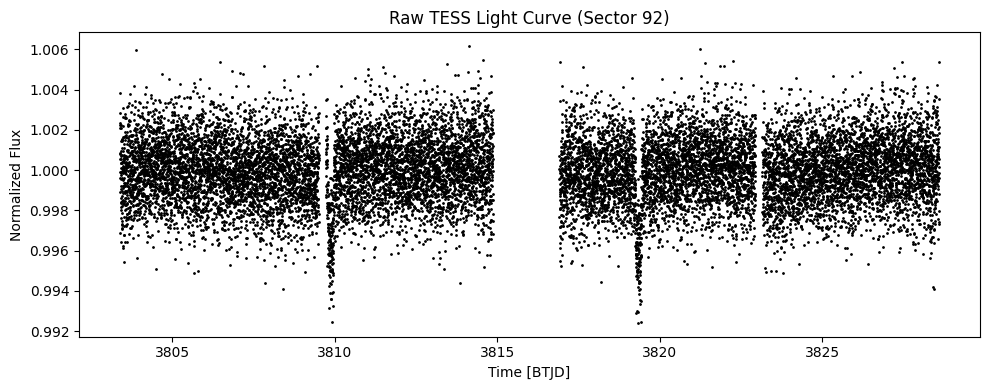

global sigma = 0.0016291119391098619 prominence min = 0.0048873358173295856
找到的候选谷值个数: 42
候选时间: [3803.50866037 3803.93648095 3804.48931425 3805.09770852 3805.65331938
 3806.20754082 3806.77981917 3807.26319958 3807.86603563 3808.42025545
 3809.09531968 3809.91484133 3810.35238222 3810.85381767 3811.29552511
 3811.73167624 3812.37479039 3812.82899814 3813.35404536 3813.85409006
 3814.57915457 3817.07104834 3817.60998851 3818.20865659 3818.71564901
 3819.34209668 3819.94354142 3820.42414118 3820.84779095 3821.62147191
 3822.35070354 3823.28134079 3823.79805222 3824.28559408 3824.84397489
 3825.26206567 3825.74682839 3826.39966012 3826.88581098 3827.36501649
 3827.8720017  3828.43176865]
Transit candidates: 3809.9148413333896 3819.342096677204


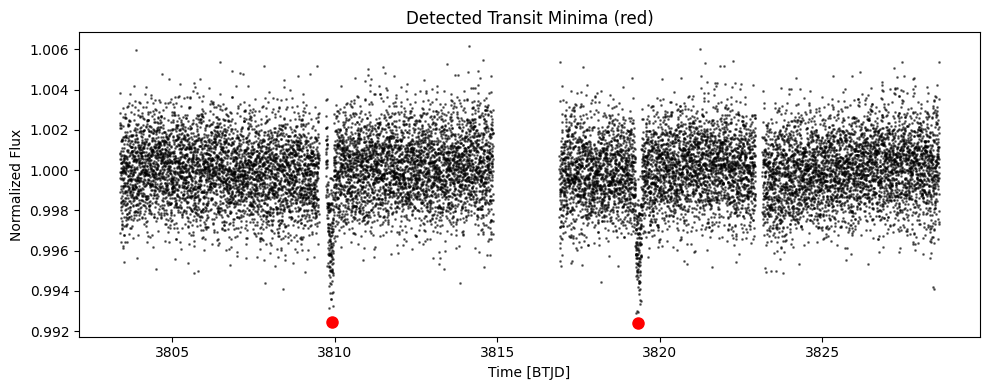

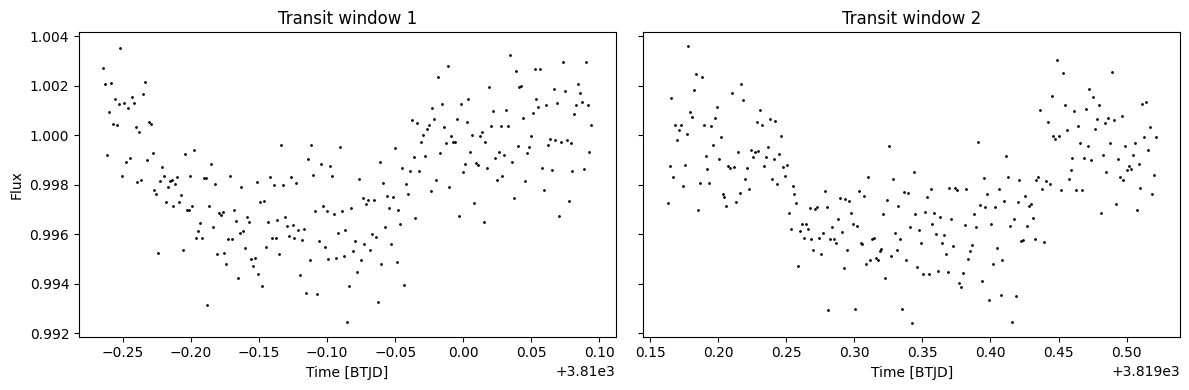

sample: 100%|██████████| 2800/2800 [00:17<00:00, 158.06it/s, 3 steps of size 6.72e-02. acc. prob=0.82] 


Transit 1 center time: 3809.692615 ± 0.015009
Transit 2 center time: 3819.117972 ± 0.013652
Difference (approx period): 9.425357 days


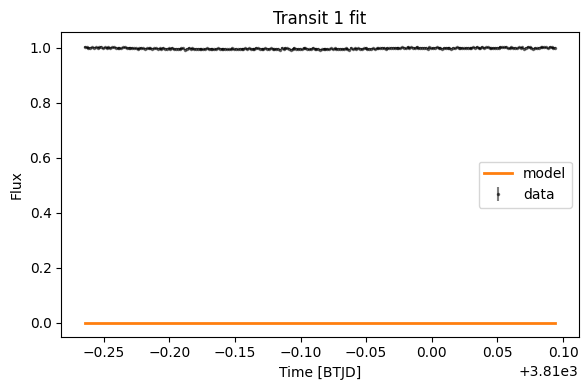

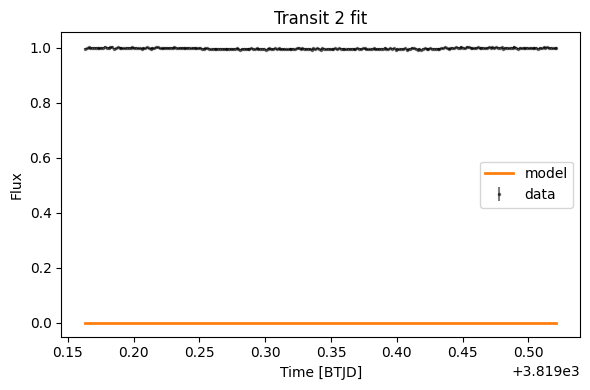

In [21]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


# ============================================
# 1. 取出 Sector 92 的真实光变
#    （如果你的 key 是 (92, 120.0)，改这里）
# ============================================
lc = sector_data[92]

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()


# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（注意键名是 "prominences"）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化检查一下是不是两次真正的 transit
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
#    window 稍微大一点，baseline 拟合更稳定
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.18):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.18)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.18)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


# ============================================
# 4. 局部 transit 模型（方案 A：加 baseline c0 + c1）
#    自由参数：t0, duration, c0, c1
#    固定：r, b, u
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    # duration：log-uniform 先验
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 固定形状参数（可以以后用全局拟合结果替代）
    r = 0.08
    b = 0.5
    u = jnp.array([0.1, 0.06])

    orbit = TransitOrbit(
        period=10.0,          # dummy，不影响局部形状
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    transit_model = limb_dark_light_curve(orbit, u)(t)

    # ⭐ 新增：局部 baseline = c0 + c1 * (t - t_mean)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.02))  # 零点稍微允许偏一点
    c1 = numpyro.sample("c1", dist.Normal(0.0, 1.0))   # 斜率，乘上 (t - t_center) 后一般很小
    baseline = c0 + c1 * (t - t_center)

    model = baseline * transit_model

    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


# ============================================
# 5. 小工具：给一段光变，返回 t0 的后验均值、标准差和 samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=800, num_samples=2000, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())
    return t0_mean, t0_std, samples


# ============================================
# 6. 分别拟合两次 transit 的中心时间
# ============================================
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")


# ============================================
# 7. 画一下每次拟合的局部 fit，肉眼检查一下
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post = float(np.mean(np.array(samples["duration"])))
    r = 0.08
    b = 0.5
    u = jnp.array([0.1, 0.06])

    t_center = t.mean()
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b,
        radius_ratio=r,
    )
    transit_model = limb_dark_light_curve(orbit, u)(t)
    baseline = c0_post + c1_post * (t - t_center)
    model = np.array(baseline * transit_model)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array, yerr=np.std(flux_array), fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")


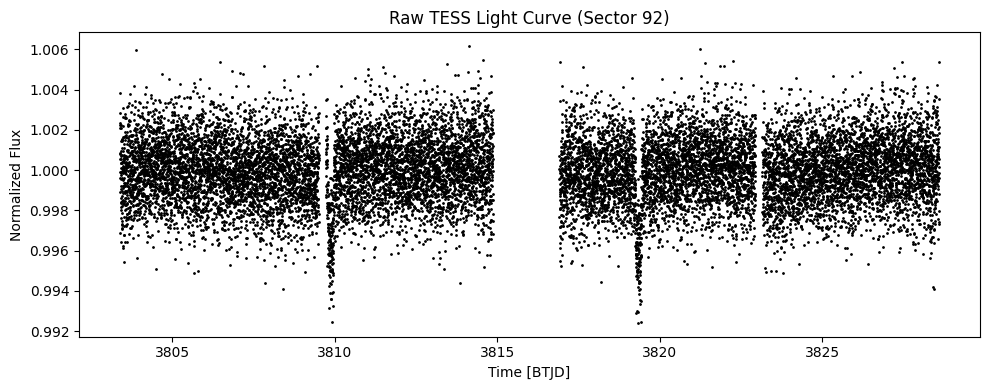

global sigma = 0.0016291119391098619 prominence min = 0.0048873358173295856
找到的候选谷值个数: 42
候选时间: [3803.50866037 3803.93648095 3804.48931425 3805.09770852 3805.65331938
 3806.20754082 3806.77981917 3807.26319958 3807.86603563 3808.42025545
 3809.09531968 3809.91484133 3810.35238222 3810.85381767 3811.29552511
 3811.73167624 3812.37479039 3812.82899814 3813.35404536 3813.85409006
 3814.57915457 3817.07104834 3817.60998851 3818.20865659 3818.71564901
 3819.34209668 3819.94354142 3820.42414118 3820.84779095 3821.62147191
 3822.35070354 3823.28134079 3823.79805222 3824.28559408 3824.84397489
 3825.26206567 3825.74682839 3826.39966012 3826.88581098 3827.36501649
 3827.8720017  3828.43176865]
Transit candidates: 3809.9148413333896 3819.342096677204


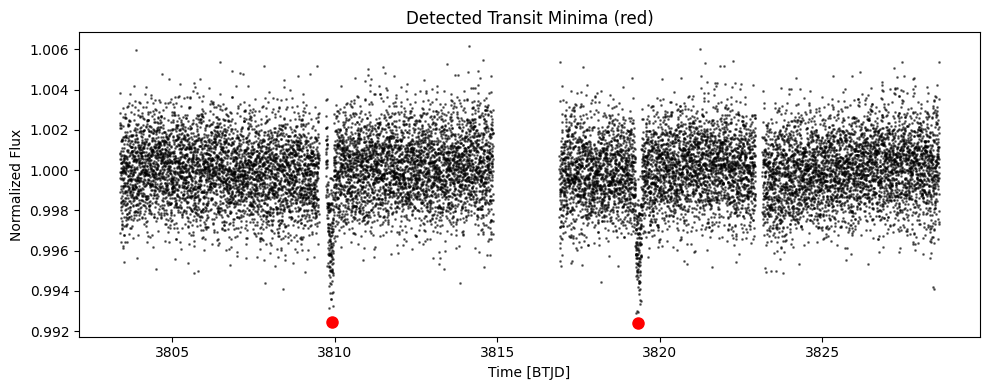

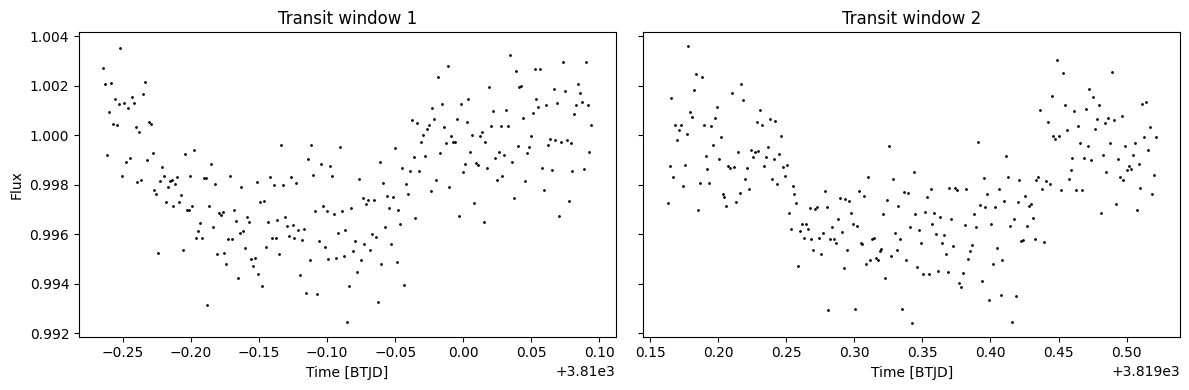

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [01:49<00:00, 31.91it/s, 127 steps of size 7.10e-03. acc. prob=0.89]


  t0 = 3809.824417 ± 0.000029
  r  = 0.1537
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [01:55<00:00, 30.33it/s, 255 steps of size 9.02e-03. acc. prob=0.93] 


  t0 = 3819.213825 ± 0.000046
  r  = 0.1615
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Transit 1 center time: 3809.824417 ± 0.000029
Transit 2 center time: 3819.213825 ± 0.000046
Difference (approx period): 9.389408 days


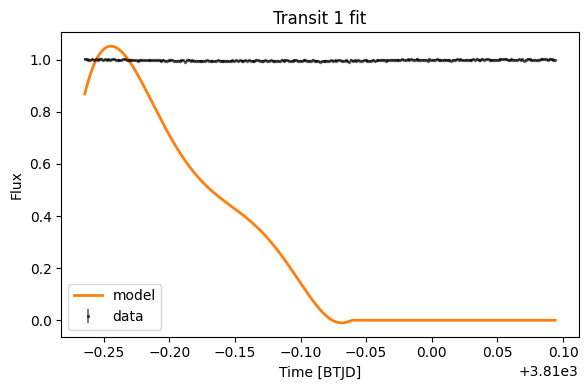

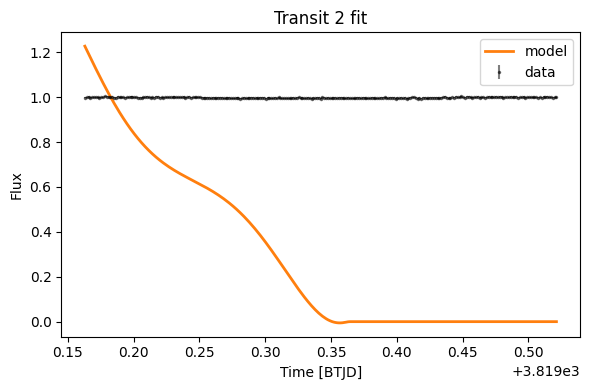

In [22]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


# ============================================
# 1. 取出 Sector 92 的真实光变
#    （如果你的 key 是 (92, 120.0)，改这里）
# ============================================
lc = sector_data[68]

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()


# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（注意键名是 "prominences"）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化检查一下是不是两次真正的 transit
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
#    window 稍微大一点，baseline 拟合更稳定
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.18):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.18)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.18)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


# ============================================
# 4. 局部 transit 模型：
#    自由参数：t0, duration, r, b, u1, u2, c0, c1
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    # duration：log-uniform 先验
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # ⭐ r: 半径比，Uniform(0.01, 0.2)
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # ⭐ b: impact parameter，通过 b_raw ∈ [-1,1] 再 abs 映射到 [0,1]
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # ⭐ limb darkening: Beta(2,2)，物理上合理的 [0,1] 内分布
    u1 = numpyro.sample("u1", dist.Beta(2.0, 2.0))
    u2 = numpyro.sample("u2", dist.Beta(2.0, 2.0))
    u = jnp.array([u1, u2])

    orbit = TransitOrbit(
        period=10.0,          # dummy，不影响局部几何
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    transit_model = limb_dark_light_curve(orbit, u)(t)

    # baseline = c0 + c1 * (t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.02))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 1.0))
    baseline = c0 + c1 * (t - t_center)

    model = baseline * transit_model

    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


# ============================================
# 5. 小工具：给一段光变，返回 t0 / r / b / u 等的后验均值、标准差和 samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())

    r_mean  = float(np.array(samples["r"]).mean())
    b_mean  = float(np.array(samples["b"]).mean())
    u1_mean = float(np.array(samples["u1"]).mean())
    u2_mean = float(np.array(samples["u2"]).mean())

    print(f"  t0 = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  r  = {r_mean:.4f}")
    print(f"  b  = {b_mean:.4f}")
    print(f"  u1 = {u1_mean:.4f}, u2 = {u2_mean:.4f}")

    return t0_mean, t0_std, samples


# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit，肉眼检查一下
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    u1_post = float(np.mean(np.array(samples["u1"])))
    u2_post = float(np.mean(np.array(samples["u2"])))
    u_post  = jnp.array([u1_post, u2_post])

    t_center = t.mean()
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )
    transit_model = limb_dark_light_curve(orbit, u_post)(t)
    baseline = c0_post + c1_post * (t - t_center)
    model = np.array(baseline * transit_model)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array, yerr=np.std(flux_array), fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")



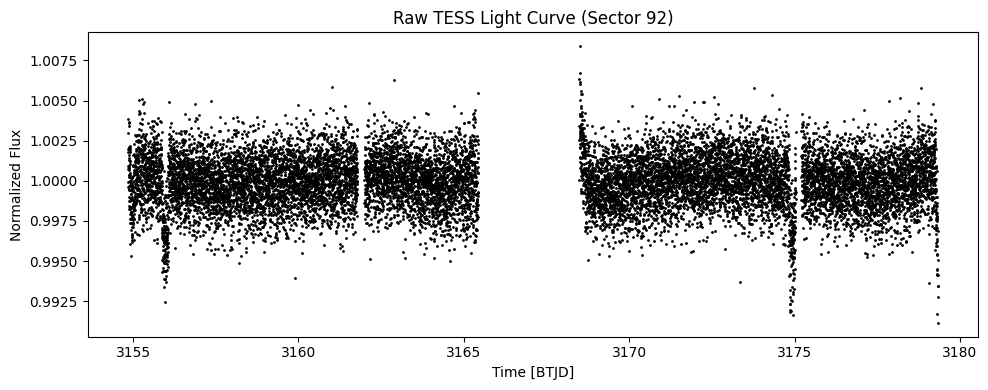

global sigma = 0.0016355710104107857 prominence min = 0.004906713031232357
找到的候选谷值个数: 39
候选时间: [3154.94786337 3155.43536992 3155.9534311  3156.81593749 3157.45344029
 3158.19094196 3158.96733109 3159.41594173 3159.89788522 3160.33399508
 3160.78538231 3161.35899083 3162.15620858 3162.68953841 3163.20620133
 3163.68397536 3164.10758294 3164.58813429 3165.20479534 3168.73948818
 3169.3880928  3169.9269746  3170.40057835 3170.92556919 3171.34222794
 3171.85332867 3172.32831843 3172.91024963 3173.35190578 3173.79217269
 3174.35188059 3174.94769809 3175.78517489 3176.2948825  3176.71153696
 3177.17957856 3177.84066955 3178.54620321 3179.31979003]
Transit candidates: 3155.953431104642 3174.9476980889576


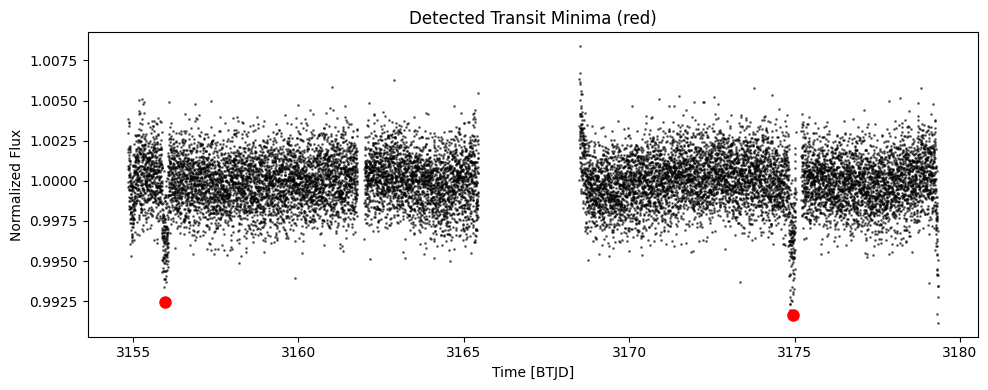

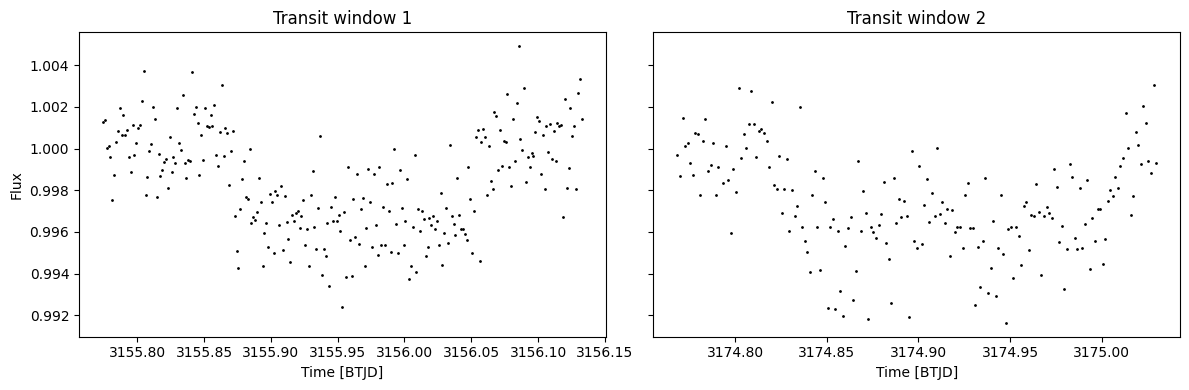

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [01:58<00:00, 29.53it/s, 255 steps of size 1.37e-02. acc. prob=0.93]


  t0 = 3155.826733 ± 0.000053
  r  = 0.1590
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [01:15<00:00, 46.40it/s, 511 steps of size 1.18e-02. acc. prob=0.93]


  t0 = 3174.899677 ± 0.000052
  r  = 0.1720
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Transit 1 center time: 3155.826733 ± 0.000053
Transit 2 center time: 3174.899677 ± 0.000052
Difference (approx period): 19.072944 days


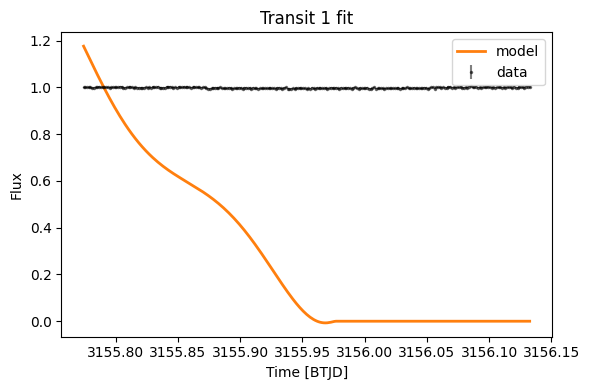

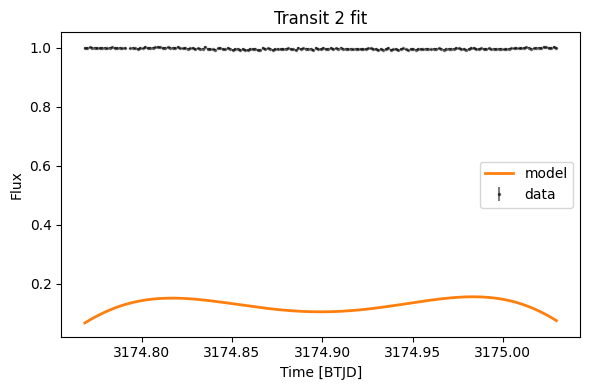

In [24]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


# ============================================
# 1. 取出 Sector 92 的真实光变
#    （如果你的 key 是 (92, 120.0)，改这里）
# ============================================
lc = sector_data[68]

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()


# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（注意键名是 "prominences"）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化检查一下是不是两次真正的 transit
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
#    window 稍微大一点，baseline 拟合更稳定
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.18):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.18)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.18)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


# ============================================
# 4. 局部 transit 模型：
#    自由参数：t0, duration, r, b, u1, u2, c0, c1
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    # duration：log-uniform 先验
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # ⭐ r: 半径比，Uniform(0.01, 0.2)
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # ⭐ b: impact parameter，通过 b_raw ∈ [-1,1] 再 abs 映射到 [0,1]
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # ⭐ limb darkening: Beta(2,2)，物理上合理的 [0,1] 内分布
    u1 = numpyro.sample("u1", dist.Beta(2.0, 2.0))
    u2 = numpyro.sample("u2", dist.Beta(2.0, 2.0))
    u = jnp.array([u1, u2])

    orbit = TransitOrbit(
        period=10.0,          # dummy，不影响局部几何
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    transit_model = limb_dark_light_curve(orbit, u)(t)

    # baseline = c0 + c1 * (t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.02))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 1.0))
    baseline = c0 + c1 * (t - t_center)

    model = baseline * transit_model

    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


# ============================================
# 5. 小工具：给一段光变，返回 t0 / r / b / u 等的后验均值、标准差和 samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())

    r_mean  = float(np.array(samples["r"]).mean())
    b_mean  = float(np.array(samples["b"]).mean())
    u1_mean = float(np.array(samples["u1"]).mean())
    u2_mean = float(np.array(samples["u2"]).mean())

    print(f"  t0 = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  r  = {r_mean:.4f}")
    print(f"  b  = {b_mean:.4f}")
    print(f"  u1 = {u1_mean:.4f}, u2 = {u2_mean:.4f}")

    return t0_mean, t0_std, samples


# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit，肉眼检查一下
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    u1_post = float(np.mean(np.array(samples["u1"])))
    u2_post = float(np.mean(np.array(samples["u2"])))
    u_post  = jnp.array([u1_post, u2_post])

    t_center = t.mean()
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )
    transit_model = limb_dark_light_curve(orbit, u_post)(t)
    baseline = c0_post + c1_post * (t - t_center)
    model = np.array(baseline * transit_model)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array, yerr=np.std(flux_array), fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")



In [25]:
print(19.072944/2)

9.536472


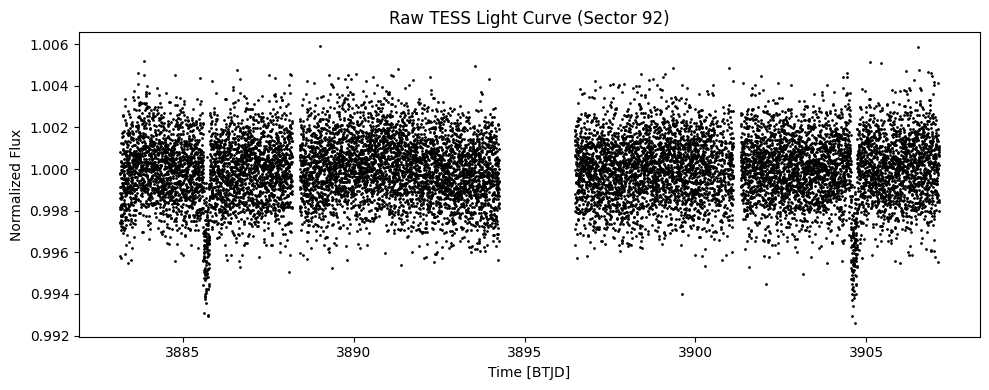

global sigma = 0.0015682571101933718 prominence min = 0.004704771330580115
找到的候选谷值个数: 38
候选时间: [3883.38874592 3883.99292182 3884.7609878  3885.22488223 3885.73460987
 3886.24155904 3886.67628478 3887.21239956 3887.64017975 3888.09712627
 3888.75129501 3889.3624071  3889.79296278 3890.37629555 3890.90407209
 3891.39018144 3891.91101222 3892.33462075 3892.77628425 3893.42488989
 3894.20682685 3897.0359754  3897.78041406 3898.43874107 3899.02901222
 3899.60261603 3900.28177297 3900.89565208 3901.58175116 3902.06785304
 3902.68450715 3903.14977484 3903.84559207 3904.68445992 3905.18027998
 3905.99275692 3906.59690551 3907.08855715]
Transit candidates: 3885.7346098721328 3904.6844599190654


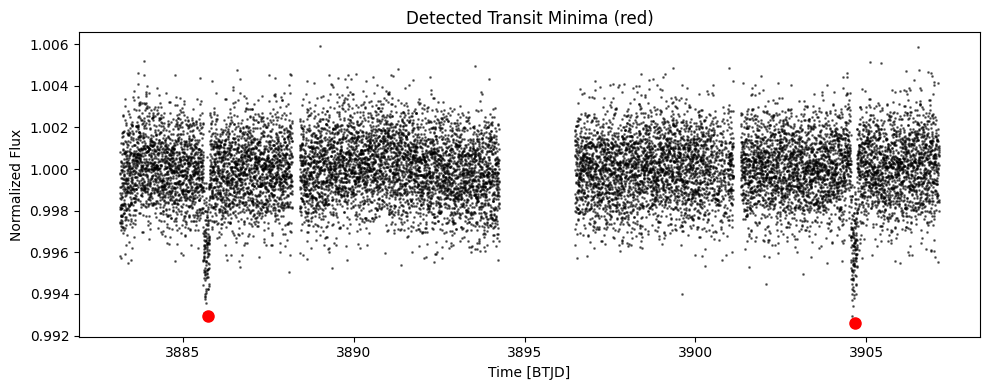

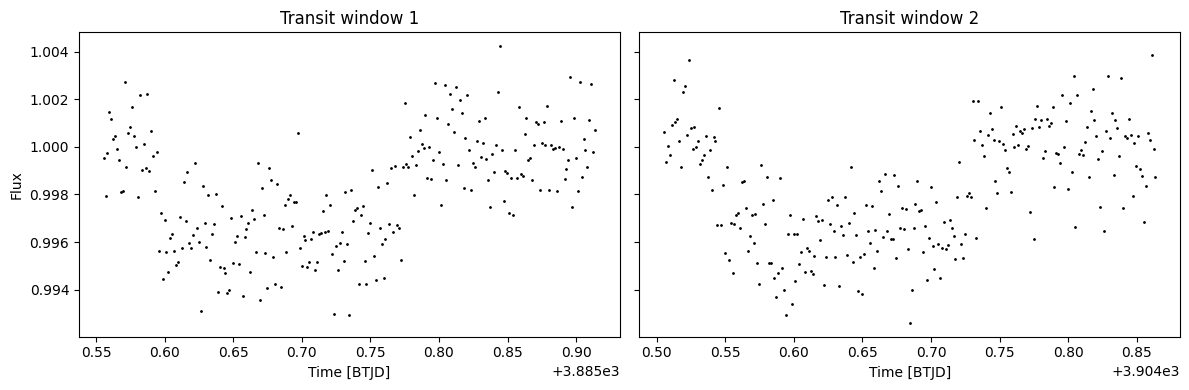

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [02:15<00:00, 25.84it/s, 67 steps of size 1.21e-02. acc. prob=0.93] 


  t0 = 3885.607298 ± 0.000045
  r  = 0.1600
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [02:20<00:00, 24.86it/s, 99 steps of size 6.89e-03. acc. prob=0.92]  


  t0 = 3904.557625 ± 0.000050
  r  = 0.1594
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Transit 1 center time: 3885.607298 ± 0.000045
Transit 2 center time: 3904.557625 ± 0.000050
Difference (approx period): 18.950327 days


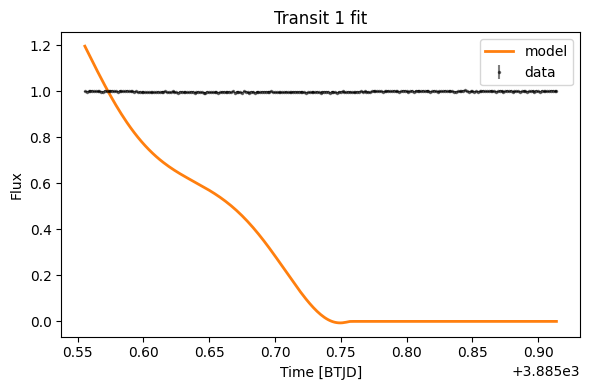

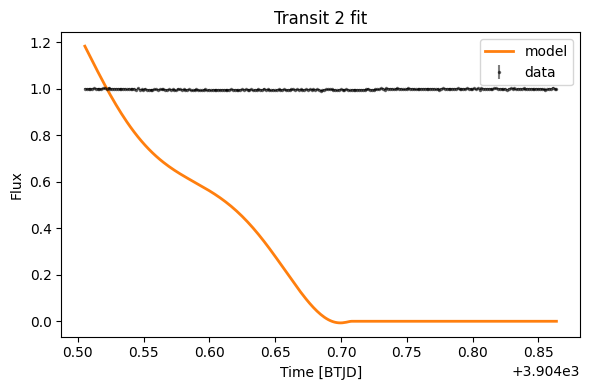

In [26]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


# ============================================
# 1. 取出 Sector 92 的真实光变
#    （如果你的 key 是 (92, 120.0)，改这里）
# ============================================
lc = sector_data[95]

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()


# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（注意键名是 "prominences"）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化检查一下是不是两次真正的 transit
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
#    window 稍微大一点，baseline 拟合更稳定
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.18):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.18)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.18)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


# ============================================
# 4. 局部 transit 模型：
#    自由参数：t0, duration, r, b, u1, u2, c0, c1
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    # duration：log-uniform 先验
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # ⭐ r: 半径比，Uniform(0.01, 0.2)
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # ⭐ b: impact parameter，通过 b_raw ∈ [-1,1] 再 abs 映射到 [0,1]
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # ⭐ limb darkening: Beta(2,2)，物理上合理的 [0,1] 内分布
    u1 = numpyro.sample("u1", dist.Beta(2.0, 2.0))
    u2 = numpyro.sample("u2", dist.Beta(2.0, 2.0))
    u = jnp.array([u1, u2])

    orbit = TransitOrbit(
        period=10.0,          # dummy，不影响局部几何
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    transit_model = limb_dark_light_curve(orbit, u)(t)

    # baseline = c0 + c1 * (t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.02))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 1.0))
    baseline = c0 + c1 * (t - t_center)

    model = baseline * transit_model

    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


# ============================================
# 5. 小工具：给一段光变，返回 t0 / r / b / u 等的后验均值、标准差和 samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())

    r_mean  = float(np.array(samples["r"]).mean())
    b_mean  = float(np.array(samples["b"]).mean())
    u1_mean = float(np.array(samples["u1"]).mean())
    u2_mean = float(np.array(samples["u2"]).mean())

    print(f"  t0 = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  r  = {r_mean:.4f}")
    print(f"  b  = {b_mean:.4f}")
    print(f"  u1 = {u1_mean:.4f}, u2 = {u2_mean:.4f}")

    return t0_mean, t0_std, samples


# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit，肉眼检查一下
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    u1_post = float(np.mean(np.array(samples["u1"])))
    u2_post = float(np.mean(np.array(samples["u2"])))
    u_post  = jnp.array([u1_post, u2_post])

    t_center = t.mean()
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )
    transit_model = limb_dark_light_curve(orbit, u_post)(t)
    baseline = c0_post + c1_post * (t - t_center)
    model = np.array(baseline * transit_model)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array, yerr=np.std(flux_array), fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")



In [27]:
print(18.950327/2)

9.4751635
